In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1t2','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b25_targets_t1t2_native_k5_b25_t1t2_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 1576)
(631390, 1)
validation
(74368, 1576)
(74368, 1)
test
(85358, 1576)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 1576)]            0         


 dense (Dense)               (None, 1024)              1614848   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 2304001 (8.79 MB)


Trainable params: 2304001 (8.79 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:16 - loss: 0.1165 - STD: 1.6642e-04 - MAE: 0.3269

 4/64 [>.............................] - ETA: 1s - loss: 0.0407 - STD: 2.2482e-04 - MAE: 0.1545  

 6/64 [=>............................] - ETA: 1s - loss: 0.0351 - STD: 1.7271e-04 - MAE: 0.1430

 8/64 [==>...........................] - ETA: 1s - loss: 0.0330 - STD: 1.3595e-04 - MAE: 0.1402

10/64 [===>..........................] - ETA: 1s - loss: 0.0317 - STD: 1.1049e-04 - MAE: 0.1383

12/64 [====>.........................] - ETA: 1s - loss: 0.0306 - STD: 9.3636e-05 - MAE: 0.1362

14/64 [=====>........................] - ETA: 1s - loss: 0.0295 - STD: 8.2864e-05 - MAE: 0.1335

16/64 [======>.......................] - ETA: 1s - loss: 0.0281 - STD: 7.6197e-05 - MAE: 0.1293

18/64 [=======>......................] - ETA: 1s - loss: 0.0265 - STD: 7.2168e-05 - MAE: 0.1245

20/64 [========>.....................] - ETA: 1s - loss: 0.0250 - STD: 6.9837e-05 - MAE: 0.1197

22/64 [=========>....................] - ETA: 1s - loss: 0.0236 - STD: 6.8213e-05 - MAE: 0.1162

24/64 [==========>...................] - ETA: 1s - loss: 0.0226 - STD: 6.6611e-05 - MAE: 0.1141

26/64 [===========>..................] - ETA: 1s - loss: 0.0219 - STD: 6.4910e-05 - MAE: 0.1128

28/64 [============>.................] - ETA: 1s - loss: 0.0215 - STD: 6.2712e-05 - MAE: 0.1114

31/64 [=============>................] - ETA: 1s - loss: 0.0204 - STD: 5.9023e-05 - MAE: 0.1088

34/64 [==============>...............] - ETA: 1s - loss: 0.0195 - STD: 5.5430e-05 - MAE: 0.1059

36/64 [===============>..............] - ETA: 1s - loss: 0.0190 - STD: 5.3060e-05 - MAE: 0.1043

38/64 [================>.............] - ETA: 1s - loss: 0.0185 - STD: 5.0906e-05 - MAE: 0.1028

40/64 [=================>............] - ETA: 1s - loss: 0.0181 - STD: 4.9017e-05 - MAE: 0.1015

42/64 [==================>...........] - ETA: 0s - loss: 0.0177 - STD: 4.7320e-05 - MAE: 0.1002

44/64 [===================>..........] - ETA: 0s - loss: 0.0174 - STD: 4.5817e-05 - MAE: 0.0992

46/64 [====================>.........] - ETA: 0s - loss: 0.0170 - STD: 4.4460e-05 - MAE: 0.0982

48/64 [=====================>........] - ETA: 0s - loss: 0.0167 - STD: 4.3223e-05 - MAE: 0.0975

50/64 [======================>.......] - ETA: 0s - loss: 0.0165 - STD: 4.2101e-05 - MAE: 0.0968

52/64 [=======================>......] - ETA: 0s - loss: 0.0162 - STD: 4.1042e-05 - MAE: 0.0962

54/64 [========================>.....] - ETA: 0s - loss: 0.0160 - STD: 4.0051e-05 - MAE: 0.0956

56/64 [=========================>....] - ETA: 0s - loss: 0.0158 - STD: 3.9070e-05 - MAE: 0.0950

58/64 [==========================>...] - ETA: 0s - loss: 0.0156 - STD: 3.8166e-05 - MAE: 0.0944

60/64 [===========================>..] - ETA: 0s - loss: 0.0154 - STD: 3.7294e-05 - MAE: 0.0938

62/64 [============================>.] - ETA: 0s - loss: 0.0152 - STD: 3.6471e-05 - MAE: 0.0933

64/64 [==============================] - ETA: 0s - loss: 0.0150 - STD: 3.5693e-05 - MAE: 0.0927

64/64 [==============================] - 5s 54ms/step - loss: 0.0150 - STD: 3.5693e-05 - MAE: 0.0927 - val_loss: 0.0094 - val_STD: 3.8741e-06 - val_MAE: 0.0758


Epoch 2/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0101 - STD: 1.2101e-05 - MAE: 0.0778

 3/64 [>.............................] - ETA: 2s - loss: 0.0101 - STD: 1.2839e-05 - MAE: 0.0781

 5/64 [=>............................] - ETA: 2s - loss: 0.0100 - STD: 1.2640e-05 - MAE: 0.0781

 7/64 [==>...........................] - ETA: 2s - loss: 0.0100 - STD: 1.2518e-05 - MAE: 0.0783

 9/64 [===>..........................] - ETA: 1s - loss: 0.0100 - STD: 1.2580e-05 - MAE: 0.0784

11/64 [====>.........................] - ETA: 1s - loss: 0.0100 - STD: 1.2465e-05 - MAE: 0.0784

13/64 [=====>........................] - ETA: 1s - loss: 0.0100 - STD: 1.2516e-05 - MAE: 0.0784

15/64 [======>.......................] - ETA: 1s - loss: 0.0100 - STD: 1.2452e-05 - MAE: 0.0784

17/64 [======>.......................] - ETA: 1s - loss: 0.0099 - STD: 1.2521e-05 - MAE: 0.0782

19/64 [=======>......................] - ETA: 1s - loss: 0.0099 - STD: 1.2597e-05 - MAE: 0.0781

21/64 [========>.....................] - ETA: 1s - loss: 0.0099 - STD: 1.2642e-05 - MAE: 0.0780

23/64 [=========>....................] - ETA: 1s - loss: 0.0099 - STD: 1.2656e-05 - MAE: 0.0779

25/64 [==========>...................] - ETA: 1s - loss: 0.0099 - STD: 1.2671e-05 - MAE: 0.0780

27/64 [===========>..................] - ETA: 1s - loss: 0.0099 - STD: 1.2729e-05 - MAE: 0.0779

29/64 [============>.................] - ETA: 1s - loss: 0.0099 - STD: 1.2725e-05 - MAE: 0.0779

31/64 [=============>................] - ETA: 1s - loss: 0.0099 - STD: 1.2795e-05 - MAE: 0.0780

33/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 1.2848e-05 - MAE: 0.0780

35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 1.2864e-05 - MAE: 0.0780

37/64 [================>.............] - ETA: 0s - loss: 0.0099 - STD: 1.2867e-05 - MAE: 0.0780

40/64 [=================>............] - ETA: 0s - loss: 0.0099 - STD: 1.2890e-05 - MAE: 0.0779

42/64 [==================>...........] - ETA: 0s - loss: 0.0099 - STD: 1.2900e-05 - MAE: 0.0779

44/64 [===================>..........] - ETA: 0s - loss: 0.0099 - STD: 1.2891e-05 - MAE: 0.0779

46/64 [====================>.........] - ETA: 0s - loss: 0.0099 - STD: 1.2915e-05 - MAE: 0.0779

48/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 1.2975e-05 - MAE: 0.0779

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 1.2997e-05 - MAE: 0.0779

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 1.3012e-05 - MAE: 0.0779

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 1.3065e-05 - MAE: 0.0779

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 1.3070e-05 - MAE: 0.0779

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 1.3116e-05 - MAE: 0.0779

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 1.3152e-05 - MAE: 0.0779

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 1.3212e-05 - MAE: 0.0779

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 1.3253e-05 - MAE: 0.0779

64/64 [==============================] - 3s 39ms/step - loss: 0.0099 - STD: 1.3253e-05 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 5.3206e-06 - val_MAE: 0.0764


Epoch 3/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0097 - STD: 1.4362e-05 - MAE: 0.0768

 3/64 [>.............................] - ETA: 2s - loss: 0.0099 - STD: 1.3971e-05 - MAE: 0.0776

 5/64 [=>............................] - ETA: 2s - loss: 0.0098 - STD: 1.3752e-05 - MAE: 0.0774

 7/64 [==>...........................] - ETA: 2s - loss: 0.0098 - STD: 1.3659e-05 - MAE: 0.0776

 9/64 [===>..........................] - ETA: 1s - loss: 0.0099 - STD: 1.3696e-05 - MAE: 0.0778

11/64 [====>.........................] - ETA: 1s - loss: 0.0099 - STD: 1.3605e-05 - MAE: 0.0780

13/64 [=====>........................] - ETA: 1s - loss: 0.0099 - STD: 1.3508e-05 - MAE: 0.0780

15/64 [======>.......................] - ETA: 1s - loss: 0.0099 - STD: 1.3535e-05 - MAE: 0.0781

17/64 [======>.......................] - ETA: 1s - loss: 0.0100 - STD: 1.3530e-05 - MAE: 0.0782

19/64 [=======>......................] - ETA: 1s - loss: 0.0100 - STD: 1.3482e-05 - MAE: 0.0782

22/64 [=========>....................] - ETA: 1s - loss: 0.0100 - STD: 1.3447e-05 - MAE: 0.0783

24/64 [==========>...................] - ETA: 1s - loss: 0.0100 - STD: 1.3446e-05 - MAE: 0.0783

26/64 [===========>..................] - ETA: 1s - loss: 0.0100 - STD: 1.3462e-05 - MAE: 0.0783

28/64 [============>.................] - ETA: 1s - loss: 0.0099 - STD: 1.3511e-05 - MAE: 0.0782

30/64 [=============>................] - ETA: 1s - loss: 0.0099 - STD: 1.3557e-05 - MAE: 0.0782

32/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 1.3628e-05 - MAE: 0.0781

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 1.3647e-05 - MAE: 0.0781

36/64 [===============>..............] - ETA: 0s - loss: 0.0099 - STD: 1.3647e-05 - MAE: 0.0781

38/64 [================>.............] - ETA: 0s - loss: 0.0099 - STD: 1.3650e-05 - MAE: 0.0780

40/64 [=================>............] - ETA: 0s - loss: 0.0099 - STD: 1.3630e-05 - MAE: 0.0780

42/64 [==================>...........] - ETA: 0s - loss: 0.0099 - STD: 1.3644e-05 - MAE: 0.0780

44/64 [===================>..........] - ETA: 0s - loss: 0.0099 - STD: 1.3697e-05 - MAE: 0.0780

46/64 [====================>.........] - ETA: 0s - loss: 0.0099 - STD: 1.3774e-05 - MAE: 0.0780

48/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 1.3842e-05 - MAE: 0.0780

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 1.3909e-05 - MAE: 0.0780

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 1.3958e-05 - MAE: 0.0780

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 1.4012e-05 - MAE: 0.0780

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 1.4062e-05 - MAE: 0.0780

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 1.4115e-05 - MAE: 0.0780

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 1.4140e-05 - MAE: 0.0780

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 1.4164e-05 - MAE: 0.0780

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 1.4211e-05 - MAE: 0.0780

64/64 [==============================] - 2s 38ms/step - loss: 0.0099 - STD: 1.4211e-05 - MAE: 0.0780 - val_loss: 0.0094 - val_STD: 7.6857e-06 - val_MAE: 0.0763


Epoch 4/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0102 - STD: 1.5594e-05 - MAE: 0.0785

 3/64 [>.............................] - ETA: 2s - loss: 0.0100 - STD: 1.6089e-05 - MAE: 0.0779

 5/64 [=>............................] - ETA: 2s - loss: 0.0099 - STD: 1.6239e-05 - MAE: 0.0777

 7/64 [==>...........................] - ETA: 2s - loss: 0.0099 - STD: 1.6369e-05 - MAE: 0.0779

 9/64 [===>..........................] - ETA: 2s - loss: 0.0100 - STD: 1.6489e-05 - MAE: 0.0781

11/64 [====>.........................] - ETA: 1s - loss: 0.0100 - STD: 1.6663e-05 - MAE: 0.0781

13/64 [=====>........................] - ETA: 1s - loss: 0.0100 - STD: 1.6797e-05 - MAE: 0.0781

15/64 [======>.......................] - ETA: 1s - loss: 0.0100 - STD: 1.6897e-05 - MAE: 0.0782

17/64 [======>.......................] - ETA: 1s - loss: 0.0099 - STD: 1.7000e-05 - MAE: 0.0781

19/64 [=======>......................] - ETA: 1s - loss: 0.0099 - STD: 1.7110e-05 - MAE: 0.0780

21/64 [========>.....................] - ETA: 1s - loss: 0.0099 - STD: 1.7145e-05 - MAE: 0.0779

23/64 [=========>....................] - ETA: 1s - loss: 0.0099 - STD: 1.7184e-05 - MAE: 0.0779

25/64 [==========>...................] - ETA: 1s - loss: 0.0099 - STD: 1.7260e-05 - MAE: 0.0779

27/64 [===========>..................] - ETA: 1s - loss: 0.0099 - STD: 1.7374e-05 - MAE: 0.0779

29/64 [============>.................] - ETA: 1s - loss: 0.0099 - STD: 1.7499e-05 - MAE: 0.0779

31/64 [=============>................] - ETA: 1s - loss: 0.0099 - STD: 1.7636e-05 - MAE: 0.0779

33/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 1.7705e-05 - MAE: 0.0779

35/64 [===============>..............] - ETA: 0s - loss: 0.0099 - STD: 1.7818e-05 - MAE: 0.0779

37/64 [================>.............] - ETA: 0s - loss: 0.0099 - STD: 1.7941e-05 - MAE: 0.0779

39/64 [=================>............] - ETA: 0s - loss: 0.0099 - STD: 1.8022e-05 - MAE: 0.0779

41/64 [==================>...........] - ETA: 0s - loss: 0.0099 - STD: 1.8120e-05 - MAE: 0.0779

43/64 [===================>..........] - ETA: 0s - loss: 0.0099 - STD: 1.8189e-05 - MAE: 0.0778

46/64 [====================>.........] - ETA: 0s - loss: 0.0099 - STD: 1.8293e-05 - MAE: 0.0778

48/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 1.8418e-05 - MAE: 0.0778

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 1.8523e-05 - MAE: 0.0778

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 1.8633e-05 - MAE: 0.0778

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 1.8730e-05 - MAE: 0.0778

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 1.8845e-05 - MAE: 0.0779

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 1.8973e-05 - MAE: 0.0779

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 1.9122e-05 - MAE: 0.0778

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 1.9275e-05 - MAE: 0.0778

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 1.9409e-05 - MAE: 0.0779

64/64 [==============================] - 2s 38ms/step - loss: 0.0099 - STD: 1.9409e-05 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 1.5598e-05 - val_MAE: 0.0765


Epoch 5/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0100 - STD: 2.4857e-05 - MAE: 0.0782

 4/64 [>.............................] - ETA: 1s - loss: 0.0100 - STD: 2.4413e-05 - MAE: 0.0778

 6/64 [=>............................] - ETA: 1s - loss: 0.0099 - STD: 2.4427e-05 - MAE: 0.0780

 8/64 [==>...........................] - ETA: 1s - loss: 0.0099 - STD: 2.4480e-05 - MAE: 0.0779

10/64 [===>..........................] - ETA: 1s - loss: 0.0099 - STD: 2.4841e-05 - MAE: 0.0780

12/64 [====>.........................] - ETA: 1s - loss: 0.0099 - STD: 2.5025e-05 - MAE: 0.0779

14/64 [=====>........................] - ETA: 1s - loss: 0.0099 - STD: 2.5271e-05 - MAE: 0.0778

16/64 [======>.......................] - ETA: 1s - loss: 0.0099 - STD: 2.5534e-05 - MAE: 0.0778

18/64 [=======>......................] - ETA: 1s - loss: 0.0099 - STD: 2.5774e-05 - MAE: 0.0778

20/64 [========>.....................] - ETA: 1s - loss: 0.0099 - STD: 2.5946e-05 - MAE: 0.0778

22/64 [=========>....................] - ETA: 1s - loss: 0.0099 - STD: 2.6157e-05 - MAE: 0.0778

24/64 [==========>...................] - ETA: 1s - loss: 0.0099 - STD: 2.6323e-05 - MAE: 0.0779

26/64 [===========>..................] - ETA: 1s - loss: 0.0099 - STD: 2.6552e-05 - MAE: 0.0780

28/64 [============>.................] - ETA: 1s - loss: 0.0099 - STD: 2.6800e-05 - MAE: 0.0780

30/64 [=============>................] - ETA: 1s - loss: 0.0099 - STD: 2.7009e-05 - MAE: 0.0779

32/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 2.7257e-05 - MAE: 0.0779

34/64 [==============>...............] - ETA: 0s - loss: 0.0099 - STD: 2.7503e-05 - MAE: 0.0778

36/64 [===============>..............] - ETA: 0s - loss: 0.0099 - STD: 2.7709e-05 - MAE: 0.0778

38/64 [================>.............] - ETA: 0s - loss: 0.0099 - STD: 2.7968e-05 - MAE: 0.0778

40/64 [=================>............] - ETA: 0s - loss: 0.0099 - STD: 2.8283e-05 - MAE: 0.0778

42/64 [==================>...........] - ETA: 0s - loss: 0.0099 - STD: 2.8619e-05 - MAE: 0.0778

44/64 [===================>..........] - ETA: 0s - loss: 0.0099 - STD: 2.8924e-05 - MAE: 0.0778

46/64 [====================>.........] - ETA: 0s - loss: 0.0099 - STD: 2.9248e-05 - MAE: 0.0778

48/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 2.9587e-05 - MAE: 0.0778

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 2.9914e-05 - MAE: 0.0778

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 3.0252e-05 - MAE: 0.0778

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 3.0585e-05 - MAE: 0.0778

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 3.0931e-05 - MAE: 0.0778

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 3.1315e-05 - MAE: 0.0778

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 3.1701e-05 - MAE: 0.0779

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 3.2039e-05 - MAE: 0.0779

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 3.2397e-05 - MAE: 0.0779

64/64 [==============================] - 2s 38ms/step - loss: 0.0099 - STD: 3.2397e-05 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 3.2237e-05 - val_MAE: 0.0764


Epoch 6/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0099 - STD: 4.4063e-05 - MAE: 0.0780

 3/64 [>.............................] - ETA: 2s - loss: 0.0098 - STD: 4.5520e-05 - MAE: 0.0776

 6/64 [=>............................] - ETA: 1s - loss: 0.0100 - STD: 4.6498e-05 - MAE: 0.0781

 8/64 [==>...........................] - ETA: 1s - loss: 0.0099 - STD: 4.7149e-05 - MAE: 0.0780

10/64 [===>..........................] - ETA: 1s - loss: 0.0099 - STD: 4.7901e-05 - MAE: 0.0779

12/64 [====>.........................] - ETA: 1s - loss: 0.0099 - STD: 4.8592e-05 - MAE: 0.0779

14/64 [=====>........................] - ETA: 1s - loss: 0.0099 - STD: 4.9261e-05 - MAE: 0.0779

16/64 [======>.......................] - ETA: 1s - loss: 0.0099 - STD: 5.0024e-05 - MAE: 0.0779

18/64 [=======>......................] - ETA: 1s - loss: 0.0099 - STD: 5.0575e-05 - MAE: 0.0780

20/64 [========>.....................] - ETA: 1s - loss: 0.0099 - STD: 5.1247e-05 - MAE: 0.0780

22/64 [=========>....................] - ETA: 1s - loss: 0.0099 - STD: 5.1907e-05 - MAE: 0.0779

24/64 [==========>...................] - ETA: 1s - loss: 0.0099 - STD: 5.2605e-05 - MAE: 0.0779

26/64 [===========>..................] - ETA: 1s - loss: 0.0099 - STD: 5.3252e-05 - MAE: 0.0778

28/64 [============>.................] - ETA: 1s - loss: 0.0099 - STD: 5.3988e-05 - MAE: 0.0778

30/64 [=============>................] - ETA: 1s - loss: 0.0099 - STD: 5.4704e-05 - MAE: 0.0778

32/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 5.5515e-05 - MAE: 0.0778

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 5.6330e-05 - MAE: 0.0778

36/64 [===============>..............] - ETA: 0s - loss: 0.0099 - STD: 5.7195e-05 - MAE: 0.0778

38/64 [================>.............] - ETA: 0s - loss: 0.0099 - STD: 5.8132e-05 - MAE: 0.0779

40/64 [=================>............] - ETA: 0s - loss: 0.0099 - STD: 5.9068e-05 - MAE: 0.0778

42/64 [==================>...........] - ETA: 0s - loss: 0.0099 - STD: 6.0022e-05 - MAE: 0.0778

44/64 [===================>..........] - ETA: 0s - loss: 0.0099 - STD: 6.1032e-05 - MAE: 0.0778

46/64 [====================>.........] - ETA: 0s - loss: 0.0099 - STD: 6.2092e-05 - MAE: 0.0778

48/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 6.3166e-05 - MAE: 0.0778

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 6.4272e-05 - MAE: 0.0778

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 6.5423e-05 - MAE: 0.0778

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 6.6614e-05 - MAE: 0.0778

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 6.7834e-05 - MAE: 0.0779

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 6.9090e-05 - MAE: 0.0778

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 7.0368e-05 - MAE: 0.0778

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 7.1705e-05 - MAE: 0.0779

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 7.3115e-05 - MAE: 0.0779

64/64 [==============================] - 3s 39ms/step - loss: 0.0099 - STD: 7.3115e-05 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 9.2619e-05 - val_MAE: 0.0766


Epoch 7/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0100 - STD: 1.1986e-04 - MAE: 0.0784

 3/64 [>.............................] - ETA: 2s - loss: 0.0100 - STD: 1.2296e-04 - MAE: 0.0784

 5/64 [=>............................] - ETA: 2s - loss: 0.0099 - STD: 1.2563e-04 - MAE: 0.0781

 8/64 [==>...........................] - ETA: 1s - loss: 0.0099 - STD: 1.2917e-04 - MAE: 0.0778

10/64 [===>..........................] - ETA: 1s - loss: 0.0098 - STD: 1.3191e-04 - MAE: 0.0776

12/64 [====>.........................] - ETA: 1s - loss: 0.0098 - STD: 1.3485e-04 - MAE: 0.0776

14/64 [=====>........................] - ETA: 1s - loss: 0.0098 - STD: 1.3796e-04 - MAE: 0.0777

16/64 [======>.......................] - ETA: 1s - loss: 0.0098 - STD: 1.4110e-04 - MAE: 0.0777

18/64 [=======>......................] - ETA: 1s - loss: 0.0099 - STD: 1.4446e-04 - MAE: 0.0778

20/64 [========>.....................] - ETA: 1s - loss: 0.0099 - STD: 1.4774e-04 - MAE: 0.0778

22/64 [=========>....................] - ETA: 1s - loss: 0.0099 - STD: 1.5111e-04 - MAE: 0.0778

24/64 [==========>...................] - ETA: 1s - loss: 0.0099 - STD: 1.5459e-04 - MAE: 0.0778

26/64 [===========>..................] - ETA: 1s - loss: 0.0099 - STD: 1.5859e-04 - MAE: 0.0778

28/64 [============>.................] - ETA: 1s - loss: 0.0099 - STD: 1.6280e-04 - MAE: 0.0778

30/64 [=============>................] - ETA: 1s - loss: 0.0099 - STD: 1.6699e-04 - MAE: 0.0778

32/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 1.7119e-04 - MAE: 0.0778

34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 1.7562e-04 - MAE: 0.0778

36/64 [===============>..............] - ETA: 0s - loss: 0.0099 - STD: 1.8047e-04 - MAE: 0.0778

38/64 [================>.............] - ETA: 0s - loss: 0.0099 - STD: 1.8558e-04 - MAE: 0.0778

40/64 [=================>............] - ETA: 0s - loss: 0.0099 - STD: 1.9091e-04 - MAE: 0.0779

42/64 [==================>...........] - ETA: 0s - loss: 0.0099 - STD: 1.9662e-04 - MAE: 0.0779

44/64 [===================>..........] - ETA: 0s - loss: 0.0099 - STD: 2.0251e-04 - MAE: 0.0778

46/64 [====================>.........] - ETA: 0s - loss: 0.0099 - STD: 2.0854e-04 - MAE: 0.0778

48/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 2.1475e-04 - MAE: 0.0778

50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 2.2140e-04 - MAE: 0.0777

52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 2.2865e-04 - MAE: 0.0778

54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 2.3658e-04 - MAE: 0.0778

56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 2.4472e-04 - MAE: 0.0778

58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 2.5313e-04 - MAE: 0.0778

60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 2.6214e-04 - MAE: 0.0778

62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 2.7169e-04 - MAE: 0.0778

64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 2.8204e-04 - MAE: 0.0778

64/64 [==============================] - 3s 39ms/step - loss: 0.0099 - STD: 2.8204e-04 - MAE: 0.0778 - val_loss: 0.0094 - val_STD: 5.0101e-04 - val_MAE: 0.0765


Epoch 8/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0099 - STD: 6.3482e-04 - MAE: 0.0776

 3/64 [>.............................] - ETA: 2s - loss: 0.0098 - STD: 6.5867e-04 - MAE: 0.0777

 5/64 [=>............................] - ETA: 2s - loss: 0.0098 - STD: 6.8265e-04 - MAE: 0.0779

 7/64 [==>...........................] - ETA: 1s - loss: 0.0098 - STD: 7.0800e-04 - MAE: 0.0777

10/64 [===>..........................] - ETA: 1s - loss: 0.0098 - STD: 7.4498e-04 - MAE: 0.0774

12/64 [====>.........................] - ETA: 1s - loss: 0.0098 - STD: 7.7581e-04 - MAE: 0.0775

14/64 [=====>........................] - ETA: 1s - loss: 0.0098 - STD: 8.1005e-04 - MAE: 0.0776

16/64 [======>.......................] - ETA: 1s - loss: 0.0098 - STD: 8.4654e-04 - MAE: 0.0776

18/64 [=======>......................] - ETA: 1s - loss: 0.0098 - STD: 8.8281e-04 - MAE: 0.0775

20/64 [========>.....................] - ETA: 1s - loss: 0.0098 - STD: 9.2161e-04 - MAE: 0.0775

22/64 [=========>....................] - ETA: 1s - loss: 0.0098 - STD: 9.6682e-04 - MAE: 0.0776

24/64 [==========>...................] - ETA: 1s - loss: 0.0098 - STD: 0.0010 - MAE: 0.0776    

26/64 [===========>..................] - ETA: 1s - loss: 0.0098 - STD: 0.0011 - MAE: 0.0776

28/64 [============>.................] - ETA: 1s - loss: 0.0098 - STD: 0.0011 - MAE: 0.0775

30/64 [=============>................] - ETA: 1s - loss: 0.0098 - STD: 0.0012 - MAE: 0.0775

32/64 [==============>...............] - ETA: 1s - loss: 0.0098 - STD: 0.0012 - MAE: 0.0775

34/64 [==============>...............] - ETA: 1s - loss: 0.0098 - STD: 0.0013 - MAE: 0.0774

36/64 [===============>..............] - ETA: 0s - loss: 0.0098 - STD: 0.0014 - MAE: 0.0774

38/64 [================>.............] - ETA: 0s - loss: 0.0097 - STD: 0.0015 - MAE: 0.0774

40/64 [=================>............] - ETA: 0s - loss: 0.0097 - STD: 0.0016 - MAE: 0.0774

42/64 [==================>...........] - ETA: 0s - loss: 0.0097 - STD: 0.0017 - MAE: 0.0774

44/64 [===================>..........] - ETA: 0s - loss: 0.0097 - STD: 0.0018 - MAE: 0.0773

46/64 [====================>.........] - ETA: 0s - loss: 0.0097 - STD: 0.0019 - MAE: 0.0773

48/64 [=====================>........] - ETA: 0s - loss: 0.0097 - STD: 0.0021 - MAE: 0.0772

50/64 [======================>.......] - ETA: 0s - loss: 0.0097 - STD: 0.0022 - MAE: 0.0772

52/64 [=======================>......] - ETA: 0s - loss: 0.0097 - STD: 0.0024 - MAE: 0.0771

54/64 [========================>.....] - ETA: 0s - loss: 0.0097 - STD: 0.0026 - MAE: 0.0771

56/64 [=========================>....] - ETA: 0s - loss: 0.0096 - STD: 0.0028 - MAE: 0.0770

58/64 [==========================>...] - ETA: 0s - loss: 0.0096 - STD: 0.0030 - MAE: 0.0769

60/64 [===========================>..] - ETA: 0s - loss: 0.0096 - STD: 0.0033 - MAE: 0.0768

62/64 [============================>.] - ETA: 0s - loss: 0.0095 - STD: 0.0036 - MAE: 0.0767

64/64 [==============================] - ETA: 0s - loss: 0.0095 - STD: 0.0039 - MAE: 0.0766

64/64 [==============================] - 2s 38ms/step - loss: 0.0095 - STD: 0.0039 - MAE: 0.0766 - val_loss: 0.0079 - val_STD: 0.0120 - val_MAE: 0.0704


Epoch 9/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0085 - STD: 0.0148 - MAE: 0.0719

 3/64 [>.............................] - ETA: 2s - loss: 0.0084 - STD: 0.0159 - MAE: 0.0724

 5/64 [=>............................] - ETA: 2s - loss: 0.0083 - STD: 0.0168 - MAE: 0.0720

 7/64 [==>...........................] - ETA: 2s - loss: 0.0083 - STD: 0.0178 - MAE: 0.0719

 9/64 [===>..........................] - ETA: 1s - loss: 0.0082 - STD: 0.0188 - MAE: 0.0714

11/64 [====>.........................] - ETA: 1s - loss: 0.0081 - STD: 0.0201 - MAE: 0.0711

13/64 [=====>........................] - ETA: 1s - loss: 0.0080 - STD: 0.0213 - MAE: 0.0707

15/64 [======>.......................] - ETA: 1s - loss: 0.0080 - STD: 0.0226 - MAE: 0.0706

17/64 [======>.......................] - ETA: 1s - loss: 0.0079 - STD: 0.0236 - MAE: 0.0701

19/64 [=======>......................] - ETA: 1s - loss: 0.0079 - STD: 0.0248 - MAE: 0.0700

21/64 [========>.....................] - ETA: 1s - loss: 0.0079 - STD: 0.0262 - MAE: 0.0698

23/64 [=========>....................] - ETA: 1s - loss: 0.0078 - STD: 0.0274 - MAE: 0.0693

25/64 [==========>...................] - ETA: 1s - loss: 0.0077 - STD: 0.0286 - MAE: 0.0690

27/64 [===========>..................] - ETA: 1s - loss: 0.0077 - STD: 0.0298 - MAE: 0.0688

29/64 [============>.................] - ETA: 1s - loss: 0.0076 - STD: 0.0309 - MAE: 0.0683

31/64 [=============>................] - ETA: 1s - loss: 0.0076 - STD: 0.0321 - MAE: 0.0681

33/64 [==============>...............] - ETA: 1s - loss: 0.0075 - STD: 0.0331 - MAE: 0.0679

35/64 [===============>..............] - ETA: 0s - loss: 0.0075 - STD: 0.0341 - MAE: 0.0675

37/64 [================>.............] - ETA: 0s - loss: 0.0074 - STD: 0.0352 - MAE: 0.0673

39/64 [=================>............] - ETA: 0s - loss: 0.0074 - STD: 0.0361 - MAE: 0.0671

41/64 [==================>...........] - ETA: 0s - loss: 0.0074 - STD: 0.0370 - MAE: 0.0669

43/64 [===================>..........] - ETA: 0s - loss: 0.0073 - STD: 0.0378 - MAE: 0.0667

46/64 [====================>.........] - ETA: 0s - loss: 0.0073 - STD: 0.0389 - MAE: 0.0664

48/64 [=====================>........] - ETA: 0s - loss: 0.0073 - STD: 0.0396 - MAE: 0.0662

50/64 [======================>.......] - ETA: 0s - loss: 0.0072 - STD: 0.0402 - MAE: 0.0661

52/64 [=======================>......] - ETA: 0s - loss: 0.0072 - STD: 0.0407 - MAE: 0.0660

54/64 [========================>.....] - ETA: 0s - loss: 0.0072 - STD: 0.0412 - MAE: 0.0658

56/64 [=========================>....] - ETA: 0s - loss: 0.0072 - STD: 0.0417 - MAE: 0.0657

58/64 [==========================>...] - ETA: 0s - loss: 0.0071 - STD: 0.0420 - MAE: 0.0655

60/64 [===========================>..] - ETA: 0s - loss: 0.0071 - STD: 0.0424 - MAE: 0.0654

62/64 [============================>.] - ETA: 0s - loss: 0.0071 - STD: 0.0428 - MAE: 0.0653

64/64 [==============================] - ETA: 0s - loss: 0.0071 - STD: 0.0431 - MAE: 0.0652

64/64 [==============================] - 2s 38ms/step - loss: 0.0071 - STD: 0.0431 - MAE: 0.0652 - val_loss: 0.0057 - val_STD: 0.0456 - val_MAE: 0.0584


Epoch 10/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0066 - STD: 0.0549 - MAE: 0.0616

 3/64 [>.............................] - ETA: 2s - loss: 0.0065 - STD: 0.0552 - MAE: 0.0621

 5/64 [=>............................] - ETA: 2s - loss: 0.0065 - STD: 0.0553 - MAE: 0.0617

 7/64 [==>...........................] - ETA: 2s - loss: 0.0065 - STD: 0.0555 - MAE: 0.0619

 9/64 [===>..........................] - ETA: 1s - loss: 0.0065 - STD: 0.0557 - MAE: 0.0619

11/64 [====>.........................] - ETA: 1s - loss: 0.0065 - STD: 0.0558 - MAE: 0.0617

13/64 [=====>........................] - ETA: 1s - loss: 0.0065 - STD: 0.0560 - MAE: 0.0618

15/64 [======>.......................] - ETA: 1s - loss: 0.0065 - STD: 0.0561 - MAE: 0.0616

17/64 [======>.......................] - ETA: 1s - loss: 0.0065 - STD: 0.0561 - MAE: 0.0616

19/64 [=======>......................] - ETA: 1s - loss: 0.0065 - STD: 0.0561 - MAE: 0.0616

22/64 [=========>....................] - ETA: 1s - loss: 0.0065 - STD: 0.0563 - MAE: 0.0615

24/64 [==========>...................] - ETA: 1s - loss: 0.0065 - STD: 0.0564 - MAE: 0.0613

26/64 [===========>..................] - ETA: 1s - loss: 0.0065 - STD: 0.0564 - MAE: 0.0614

28/64 [============>.................] - ETA: 1s - loss: 0.0065 - STD: 0.0565 - MAE: 0.0614

30/64 [=============>................] - ETA: 1s - loss: 0.0065 - STD: 0.0565 - MAE: 0.0613

32/64 [==============>...............] - ETA: 1s - loss: 0.0065 - STD: 0.0566 - MAE: 0.0613

34/64 [==============>...............] - ETA: 0s - loss: 0.0065 - STD: 0.0566 - MAE: 0.0613

36/64 [===============>..............] - ETA: 0s - loss: 0.0065 - STD: 0.0566 - MAE: 0.0613

38/64 [================>.............] - ETA: 0s - loss: 0.0065 - STD: 0.0565 - MAE: 0.0613

40/64 [=================>............] - ETA: 0s - loss: 0.0065 - STD: 0.0565 - MAE: 0.0613

42/64 [==================>...........] - ETA: 0s - loss: 0.0065 - STD: 0.0565 - MAE: 0.0613

44/64 [===================>..........] - ETA: 0s - loss: 0.0065 - STD: 0.0565 - MAE: 0.0613

46/64 [====================>.........] - ETA: 0s - loss: 0.0065 - STD: 0.0565 - MAE: 0.0613

48/64 [=====================>........] - ETA: 0s - loss: 0.0065 - STD: 0.0565 - MAE: 0.0612

50/64 [======================>.......] - ETA: 0s - loss: 0.0064 - STD: 0.0566 - MAE: 0.0612

52/64 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0566 - MAE: 0.0612

54/64 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0567 - MAE: 0.0612

56/64 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0567 - MAE: 0.0612

58/64 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.0567 - MAE: 0.0612

60/64 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0568 - MAE: 0.0612

62/64 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.0567 - MAE: 0.0612

64/64 [==============================] - ETA: 0s - loss: 0.0064 - STD: 0.0567 - MAE: 0.0612

64/64 [==============================] - 3s 39ms/step - loss: 0.0064 - STD: 0.0567 - MAE: 0.0612 - val_loss: 0.0056 - val_STD: 0.0470 - val_MAE: 0.0577


Epoch 11/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0064 - STD: 0.0561 - MAE: 0.0606

 3/64 [>.............................] - ETA: 2s - loss: 0.0063 - STD: 0.0563 - MAE: 0.0606

 5/64 [=>............................] - ETA: 2s - loss: 0.0064 - STD: 0.0566 - MAE: 0.0607

 7/64 [==>...........................] - ETA: 1s - loss: 0.0064 - STD: 0.0570 - MAE: 0.0608

 9/64 [===>..........................] - ETA: 1s - loss: 0.0064 - STD: 0.0573 - MAE: 0.0608

11/64 [====>.........................] - ETA: 1s - loss: 0.0064 - STD: 0.0575 - MAE: 0.0608

13/64 [=====>........................] - ETA: 1s - loss: 0.0064 - STD: 0.0578 - MAE: 0.0607

15/64 [======>.......................] - ETA: 1s - loss: 0.0064 - STD: 0.0579 - MAE: 0.0607

17/64 [======>.......................] - ETA: 1s - loss: 0.0064 - STD: 0.0579 - MAE: 0.0607

19/64 [=======>......................] - ETA: 1s - loss: 0.0064 - STD: 0.0580 - MAE: 0.0608

21/64 [========>.....................] - ETA: 1s - loss: 0.0064 - STD: 0.0579 - MAE: 0.0607

23/64 [=========>....................] - ETA: 1s - loss: 0.0064 - STD: 0.0578 - MAE: 0.0607

25/64 [==========>...................] - ETA: 1s - loss: 0.0064 - STD: 0.0577 - MAE: 0.0607

27/64 [===========>..................] - ETA: 1s - loss: 0.0064 - STD: 0.0577 - MAE: 0.0607

29/64 [============>.................] - ETA: 1s - loss: 0.0064 - STD: 0.0577 - MAE: 0.0607

31/64 [=============>................] - ETA: 1s - loss: 0.0064 - STD: 0.0577 - MAE: 0.0606

33/64 [==============>...............] - ETA: 1s - loss: 0.0063 - STD: 0.0577 - MAE: 0.0606

35/64 [===============>..............] - ETA: 0s - loss: 0.0063 - STD: 0.0578 - MAE: 0.0606

37/64 [================>.............] - ETA: 0s - loss: 0.0063 - STD: 0.0578 - MAE: 0.0606

39/64 [=================>............] - ETA: 0s - loss: 0.0064 - STD: 0.0578 - MAE: 0.0606

41/64 [==================>...........] - ETA: 0s - loss: 0.0064 - STD: 0.0578 - MAE: 0.0606

43/64 [===================>..........] - ETA: 0s - loss: 0.0064 - STD: 0.0578 - MAE: 0.0606

44/64 [===================>..........] - ETA: 0s - loss: 0.0064 - STD: 0.0577 - MAE: 0.0606

46/64 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0577 - MAE: 0.0606

48/64 [=====================>........] - ETA: 0s - loss: 0.0064 - STD: 0.0577 - MAE: 0.0606

50/64 [======================>.......] - ETA: 0s - loss: 0.0064 - STD: 0.0577 - MAE: 0.0606

52/64 [=======================>......] - ETA: 0s - loss: 0.0064 - STD: 0.0577 - MAE: 0.0606

54/64 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0577 - MAE: 0.0606

57/64 [=========================>....] - ETA: 0s - loss: 0.0064 - STD: 0.0578 - MAE: 0.0607

59/64 [==========================>...] - ETA: 0s - loss: 0.0064 - STD: 0.0578 - MAE: 0.0607

61/64 [===========================>..] - ETA: 0s - loss: 0.0064 - STD: 0.0579 - MAE: 0.0607

63/64 [============================>.] - ETA: 0s - loss: 0.0064 - STD: 0.0579 - MAE: 0.0606

64/64 [==============================] - 3s 39ms/step - loss: 0.0064 - STD: 0.0580 - MAE: 0.0606 - val_loss: 0.0056 - val_STD: 0.0494 - val_MAE: 0.0582


Epoch 12/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0064 - STD: 0.0587 - MAE: 0.0610

 3/64 [>.............................] - ETA: 2s - loss: 0.0063 - STD: 0.0586 - MAE: 0.0602

 5/64 [=>............................] - ETA: 2s - loss: 0.0063 - STD: 0.0585 - MAE: 0.0601

 7/64 [==>...........................] - ETA: 1s - loss: 0.0063 - STD: 0.0584 - MAE: 0.0599

 9/64 [===>..........................] - ETA: 1s - loss: 0.0063 - STD: 0.0583 - MAE: 0.0600

11/64 [====>.........................] - ETA: 1s - loss: 0.0063 - STD: 0.0583 - MAE: 0.0601

13/64 [=====>........................] - ETA: 1s - loss: 0.0063 - STD: 0.0583 - MAE: 0.0601

15/64 [======>.......................] - ETA: 1s - loss: 0.0063 - STD: 0.0584 - MAE: 0.0602

17/64 [======>.......................] - ETA: 1s - loss: 0.0063 - STD: 0.0585 - MAE: 0.0601

19/64 [=======>......................] - ETA: 1s - loss: 0.0063 - STD: 0.0586 - MAE: 0.0603

21/64 [========>.....................] - ETA: 1s - loss: 0.0063 - STD: 0.0586 - MAE: 0.0603

23/64 [=========>....................] - ETA: 1s - loss: 0.0063 - STD: 0.0586 - MAE: 0.0603

25/64 [==========>...................] - ETA: 1s - loss: 0.0063 - STD: 0.0587 - MAE: 0.0603

27/64 [===========>..................] - ETA: 1s - loss: 0.0063 - STD: 0.0587 - MAE: 0.0602

29/64 [============>.................] - ETA: 1s - loss: 0.0063 - STD: 0.0587 - MAE: 0.0602

31/64 [=============>................] - ETA: 1s - loss: 0.0063 - STD: 0.0587 - MAE: 0.0602

33/64 [==============>...............] - ETA: 1s - loss: 0.0063 - STD: 0.0587 - MAE: 0.0602

35/64 [===============>..............] - ETA: 0s - loss: 0.0063 - STD: 0.0587 - MAE: 0.0602

37/64 [================>.............] - ETA: 0s - loss: 0.0063 - STD: 0.0587 - MAE: 0.0602

39/64 [=================>............] - ETA: 0s - loss: 0.0063 - STD: 0.0588 - MAE: 0.0602

41/64 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0588 - MAE: 0.0602

43/64 [===================>..........] - ETA: 0s - loss: 0.0063 - STD: 0.0588 - MAE: 0.0602

45/64 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0588 - MAE: 0.0602

47/64 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0588 - MAE: 0.0602

49/64 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0588 - MAE: 0.0601

51/64 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0588 - MAE: 0.0601

53/64 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0588 - MAE: 0.0601

55/64 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0588 - MAE: 0.0601

57/64 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0588 - MAE: 0.0601

59/64 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0588 - MAE: 0.0601

61/64 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0588 - MAE: 0.0601

63/64 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0588 - MAE: 0.0601

64/64 [==============================] - 2s 38ms/step - loss: 0.0063 - STD: 0.0588 - MAE: 0.0601 - val_loss: 0.0055 - val_STD: 0.0494 - val_MAE: 0.0579


Epoch 13/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0061 - STD: 0.0590 - MAE: 0.0597

 3/64 [>.............................] - ETA: 2s - loss: 0.0062 - STD: 0.0589 - MAE: 0.0600

 5/64 [=>............................] - ETA: 2s - loss: 0.0062 - STD: 0.0587 - MAE: 0.0596

 7/64 [==>...........................] - ETA: 1s - loss: 0.0063 - STD: 0.0589 - MAE: 0.0603

 9/64 [===>..........................] - ETA: 1s - loss: 0.0063 - STD: 0.0590 - MAE: 0.0603

11/64 [====>.........................] - ETA: 1s - loss: 0.0063 - STD: 0.0591 - MAE: 0.0603

13/64 [=====>........................] - ETA: 1s - loss: 0.0063 - STD: 0.0591 - MAE: 0.0603

16/64 [======>.......................] - ETA: 1s - loss: 0.0063 - STD: 0.0594 - MAE: 0.0605

18/64 [=======>......................] - ETA: 1s - loss: 0.0063 - STD: 0.0593 - MAE: 0.0605

20/64 [========>.....................] - ETA: 1s - loss: 0.0063 - STD: 0.0591 - MAE: 0.0604

22/64 [=========>....................] - ETA: 1s - loss: 0.0063 - STD: 0.0590 - MAE: 0.0605

24/64 [==========>...................] - ETA: 1s - loss: 0.0063 - STD: 0.0588 - MAE: 0.0603

26/64 [===========>..................] - ETA: 1s - loss: 0.0063 - STD: 0.0588 - MAE: 0.0604

28/64 [============>.................] - ETA: 1s - loss: 0.0063 - STD: 0.0589 - MAE: 0.0604

30/64 [=============>................] - ETA: 1s - loss: 0.0063 - STD: 0.0590 - MAE: 0.0603

32/64 [==============>...............] - ETA: 1s - loss: 0.0063 - STD: 0.0591 - MAE: 0.0604

34/64 [==============>...............] - ETA: 1s - loss: 0.0063 - STD: 0.0591 - MAE: 0.0603

36/64 [===============>..............] - ETA: 0s - loss: 0.0063 - STD: 0.0591 - MAE: 0.0602

38/64 [================>.............] - ETA: 0s - loss: 0.0063 - STD: 0.0592 - MAE: 0.0602

40/64 [=================>............] - ETA: 0s - loss: 0.0063 - STD: 0.0592 - MAE: 0.0602

42/64 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0592 - MAE: 0.0602

44/64 [===================>..........] - ETA: 0s - loss: 0.0063 - STD: 0.0592 - MAE: 0.0603

46/64 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0592 - MAE: 0.0602

48/64 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0592 - MAE: 0.0602

50/64 [======================>.......] - ETA: 0s - loss: 0.0063 - STD: 0.0592 - MAE: 0.0601

52/64 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0592 - MAE: 0.0601

54/64 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0592 - MAE: 0.0601

56/64 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0592 - MAE: 0.0601

58/64 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0593 - MAE: 0.0600

60/64 [===========================>..] - ETA: 0s - loss: 0.0063 - STD: 0.0593 - MAE: 0.0600

62/64 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0593 - MAE: 0.0600

64/64 [==============================] - ETA: 0s - loss: 0.0063 - STD: 0.0593 - MAE: 0.0600

64/64 [==============================] - 2s 38ms/step - loss: 0.0063 - STD: 0.0593 - MAE: 0.0600 - val_loss: 0.0056 - val_STD: 0.0499 - val_MAE: 0.0595


Epoch 14/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0063 - STD: 0.0605 - MAE: 0.0619

 3/64 [>.............................] - ETA: 2s - loss: 0.0063 - STD: 0.0590 - MAE: 0.0603

 5/64 [=>............................] - ETA: 1s - loss: 0.0064 - STD: 0.0590 - MAE: 0.0606

 7/64 [==>...........................] - ETA: 1s - loss: 0.0063 - STD: 0.0589 - MAE: 0.0607

 9/64 [===>..........................] - ETA: 1s - loss: 0.0064 - STD: 0.0586 - MAE: 0.0604

11/64 [====>.........................] - ETA: 1s - loss: 0.0064 - STD: 0.0587 - MAE: 0.0606

13/64 [=====>........................] - ETA: 1s - loss: 0.0064 - STD: 0.0589 - MAE: 0.0606

15/64 [======>.......................] - ETA: 1s - loss: 0.0064 - STD: 0.0590 - MAE: 0.0604

17/64 [======>.......................] - ETA: 1s - loss: 0.0063 - STD: 0.0591 - MAE: 0.0604

19/64 [=======>......................] - ETA: 1s - loss: 0.0063 - STD: 0.0591 - MAE: 0.0603

21/64 [========>.....................] - ETA: 1s - loss: 0.0063 - STD: 0.0591 - MAE: 0.0602

23/64 [=========>....................] - ETA: 1s - loss: 0.0063 - STD: 0.0592 - MAE: 0.0602

25/64 [==========>...................] - ETA: 1s - loss: 0.0063 - STD: 0.0592 - MAE: 0.0601

27/64 [===========>..................] - ETA: 1s - loss: 0.0063 - STD: 0.0592 - MAE: 0.0601

29/64 [============>.................] - ETA: 1s - loss: 0.0063 - STD: 0.0593 - MAE: 0.0600

31/64 [=============>................] - ETA: 1s - loss: 0.0063 - STD: 0.0592 - MAE: 0.0600

33/64 [==============>...............] - ETA: 1s - loss: 0.0063 - STD: 0.0593 - MAE: 0.0600

35/64 [===============>..............] - ETA: 1s - loss: 0.0062 - STD: 0.0594 - MAE: 0.0599

38/64 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0594 - MAE: 0.0599

40/64 [=================>............] - ETA: 0s - loss: 0.0062 - STD: 0.0594 - MAE: 0.0599

42/64 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0594 - MAE: 0.0599

44/64 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0594 - MAE: 0.0599

46/64 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0595 - MAE: 0.0599

48/64 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0596 - MAE: 0.0599

50/64 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0596 - MAE: 0.0599

52/64 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0595 - MAE: 0.0598

54/64 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0596 - MAE: 0.0598

56/64 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0596 - MAE: 0.0598

58/64 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0596 - MAE: 0.0598

60/64 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0597 - MAE: 0.0598

62/64 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0597 - MAE: 0.0598

64/64 [==============================] - ETA: 0s - loss: 0.0062 - STD: 0.0597 - MAE: 0.0597

64/64 [==============================] - 3s 41ms/step - loss: 0.0062 - STD: 0.0597 - MAE: 0.0597 - val_loss: 0.0055 - val_STD: 0.0495 - val_MAE: 0.0574


Epoch 15/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0061 - STD: 0.0603 - MAE: 0.0594

 3/64 [>.............................] - ETA: 2s - loss: 0.0062 - STD: 0.0605 - MAE: 0.0593

 5/64 [=>............................] - ETA: 2s - loss: 0.0062 - STD: 0.0606 - MAE: 0.0596

 7/64 [==>...........................] - ETA: 2s - loss: 0.0062 - STD: 0.0604 - MAE: 0.0596

 9/64 [===>..........................] - ETA: 2s - loss: 0.0062 - STD: 0.0603 - MAE: 0.0595

11/64 [====>.........................] - ETA: 2s - loss: 0.0062 - STD: 0.0604 - MAE: 0.0595

13/64 [=====>........................] - ETA: 2s - loss: 0.0061 - STD: 0.0604 - MAE: 0.0594

16/64 [======>.......................] - ETA: 1s - loss: 0.0061 - STD: 0.0606 - MAE: 0.0596

18/64 [=======>......................] - ETA: 1s - loss: 0.0062 - STD: 0.0604 - MAE: 0.0596

20/64 [========>.....................] - ETA: 1s - loss: 0.0062 - STD: 0.0601 - MAE: 0.0597

22/64 [=========>....................] - ETA: 1s - loss: 0.0062 - STD: 0.0599 - MAE: 0.0599

24/64 [==========>...................] - ETA: 1s - loss: 0.0062 - STD: 0.0595 - MAE: 0.0598

26/64 [===========>..................] - ETA: 1s - loss: 0.0062 - STD: 0.0595 - MAE: 0.0599

28/64 [============>.................] - ETA: 1s - loss: 0.0062 - STD: 0.0597 - MAE: 0.0599

30/64 [=============>................] - ETA: 1s - loss: 0.0062 - STD: 0.0598 - MAE: 0.0598

32/64 [==============>...............] - ETA: 1s - loss: 0.0062 - STD: 0.0600 - MAE: 0.0598

34/64 [==============>...............] - ETA: 1s - loss: 0.0062 - STD: 0.0599 - MAE: 0.0598

36/64 [===============>..............] - ETA: 1s - loss: 0.0062 - STD: 0.0598 - MAE: 0.0598

38/64 [================>.............] - ETA: 0s - loss: 0.0062 - STD: 0.0597 - MAE: 0.0598

40/64 [=================>............] - ETA: 0s - loss: 0.0062 - STD: 0.0597 - MAE: 0.0598

42/64 [==================>...........] - ETA: 0s - loss: 0.0062 - STD: 0.0598 - MAE: 0.0597

44/64 [===================>..........] - ETA: 0s - loss: 0.0062 - STD: 0.0599 - MAE: 0.0598

46/64 [====================>.........] - ETA: 0s - loss: 0.0062 - STD: 0.0598 - MAE: 0.0597

48/64 [=====================>........] - ETA: 0s - loss: 0.0062 - STD: 0.0598 - MAE: 0.0598

50/64 [======================>.......] - ETA: 0s - loss: 0.0062 - STD: 0.0597 - MAE: 0.0598

52/64 [=======================>......] - ETA: 0s - loss: 0.0062 - STD: 0.0598 - MAE: 0.0598

54/64 [========================>.....] - ETA: 0s - loss: 0.0062 - STD: 0.0599 - MAE: 0.0598

56/64 [=========================>....] - ETA: 0s - loss: 0.0062 - STD: 0.0599 - MAE: 0.0597

58/64 [==========================>...] - ETA: 0s - loss: 0.0062 - STD: 0.0599 - MAE: 0.0597

60/64 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0599 - MAE: 0.0597

62/64 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0599 - MAE: 0.0597

64/64 [==============================] - ETA: 0s - loss: 0.0062 - STD: 0.0599 - MAE: 0.0597

64/64 [==============================] - 3s 41ms/step - loss: 0.0062 - STD: 0.0599 - MAE: 0.0597 - val_loss: 0.0054 - val_STD: 0.0489 - val_MAE: 0.0566


Epoch 16/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0060 - STD: 0.0607 - MAE: 0.0583

 3/64 [>.............................] - ETA: 2s - loss: 0.0060 - STD: 0.0615 - MAE: 0.0585

 5/64 [=>............................] - ETA: 2s - loss: 0.0060 - STD: 0.0616 - MAE: 0.0586

 7/64 [==>...........................] - ETA: 2s - loss: 0.0060 - STD: 0.0615 - MAE: 0.0587

 9/64 [===>..........................] - ETA: 1s - loss: 0.0060 - STD: 0.0615 - MAE: 0.0588

11/64 [====>.........................] - ETA: 1s - loss: 0.0060 - STD: 0.0613 - MAE: 0.0588

13/64 [=====>........................] - ETA: 1s - loss: 0.0060 - STD: 0.0614 - MAE: 0.0588

15/64 [======>.......................] - ETA: 1s - loss: 0.0060 - STD: 0.0615 - MAE: 0.0589

17/64 [======>.......................] - ETA: 1s - loss: 0.0060 - STD: 0.0613 - MAE: 0.0589

19/64 [=======>......................] - ETA: 1s - loss: 0.0060 - STD: 0.0612 - MAE: 0.0590

21/64 [========>.....................] - ETA: 1s - loss: 0.0061 - STD: 0.0612 - MAE: 0.0591

23/64 [=========>....................] - ETA: 1s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0591

25/64 [==========>...................] - ETA: 1s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0591

27/64 [===========>..................] - ETA: 1s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0592

29/64 [============>.................] - ETA: 1s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0591

31/64 [=============>................] - ETA: 1s - loss: 0.0061 - STD: 0.0609 - MAE: 0.0591

33/64 [==============>...............] - ETA: 1s - loss: 0.0061 - STD: 0.0610 - MAE: 0.0592

35/64 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0607 - MAE: 0.0592

37/64 [================>.............] - ETA: 0s - loss: 0.0061 - STD: 0.0607 - MAE: 0.0592

39/64 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0606 - MAE: 0.0593

41/64 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0605 - MAE: 0.0592

43/64 [===================>..........] - ETA: 0s - loss: 0.0061 - STD: 0.0606 - MAE: 0.0593

45/64 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0606 - MAE: 0.0593

47/64 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0606 - MAE: 0.0593

49/64 [=====================>........] - ETA: 0s - loss: 0.0061 - STD: 0.0606 - MAE: 0.0593

51/64 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0606 - MAE: 0.0593

53/64 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0607 - MAE: 0.0593

55/64 [========================>.....] - ETA: 0s - loss: 0.0061 - STD: 0.0607 - MAE: 0.0593

57/64 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0607 - MAE: 0.0592

60/64 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0607 - MAE: 0.0592

62/64 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0607 - MAE: 0.0592

64/64 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0608 - MAE: 0.0592

64/64 [==============================] - 3s 43ms/step - loss: 0.0061 - STD: 0.0608 - MAE: 0.0592 - val_loss: 0.0054 - val_STD: 0.0485 - val_MAE: 0.0561


Epoch 17/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0059 - STD: 0.0610 - MAE: 0.0575

 3/64 [>.............................] - ETA: 2s - loss: 0.0059 - STD: 0.0614 - MAE: 0.0582

 5/64 [=>............................] - ETA: 2s - loss: 0.0059 - STD: 0.0613 - MAE: 0.0584

 7/64 [==>...........................] - ETA: 2s - loss: 0.0059 - STD: 0.0615 - MAE: 0.0584

 9/64 [===>..........................] - ETA: 2s - loss: 0.0060 - STD: 0.0617 - MAE: 0.0585

11/64 [====>.........................] - ETA: 2s - loss: 0.0059 - STD: 0.0616 - MAE: 0.0585

13/64 [=====>........................] - ETA: 1s - loss: 0.0059 - STD: 0.0614 - MAE: 0.0585

15/64 [======>.......................] - ETA: 1s - loss: 0.0059 - STD: 0.0613 - MAE: 0.0585

17/64 [======>.......................] - ETA: 1s - loss: 0.0059 - STD: 0.0613 - MAE: 0.0584

19/64 [=======>......................] - ETA: 1s - loss: 0.0059 - STD: 0.0615 - MAE: 0.0584

21/64 [========>.....................] - ETA: 1s - loss: 0.0059 - STD: 0.0616 - MAE: 0.0585

23/64 [=========>....................] - ETA: 1s - loss: 0.0059 - STD: 0.0615 - MAE: 0.0585

25/64 [==========>...................] - ETA: 1s - loss: 0.0060 - STD: 0.0615 - MAE: 0.0585

27/64 [===========>..................] - ETA: 1s - loss: 0.0060 - STD: 0.0616 - MAE: 0.0586

29/64 [============>.................] - ETA: 1s - loss: 0.0060 - STD: 0.0614 - MAE: 0.0586

31/64 [=============>................] - ETA: 1s - loss: 0.0060 - STD: 0.0614 - MAE: 0.0585

33/64 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0616 - MAE: 0.0586

35/64 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0617 - MAE: 0.0586

37/64 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0617 - MAE: 0.0586

39/64 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0616 - MAE: 0.0586

41/64 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0616 - MAE: 0.0587

43/64 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0614 - MAE: 0.0587

45/64 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0613 - MAE: 0.0588

47/64 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0613 - MAE: 0.0590

49/64 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0609 - MAE: 0.0590

51/64 [======================>.......] - ETA: 0s - loss: 0.0061 - STD: 0.0608 - MAE: 0.0591

53/64 [=======================>......] - ETA: 0s - loss: 0.0061 - STD: 0.0606 - MAE: 0.0591

56/64 [=========================>....] - ETA: 0s - loss: 0.0061 - STD: 0.0605 - MAE: 0.0592

58/64 [==========================>...] - ETA: 0s - loss: 0.0061 - STD: 0.0605 - MAE: 0.0592

60/64 [===========================>..] - ETA: 0s - loss: 0.0061 - STD: 0.0604 - MAE: 0.0592

62/64 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0604 - MAE: 0.0592

64/64 [==============================] - ETA: 0s - loss: 0.0061 - STD: 0.0605 - MAE: 0.0592

64/64 [==============================] - 3s 42ms/step - loss: 0.0061 - STD: 0.0605 - MAE: 0.0592 - val_loss: 0.0053 - val_STD: 0.0504 - val_MAE: 0.0559


Epoch 18/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0058 - STD: 0.0628 - MAE: 0.0573

 3/64 [>.............................] - ETA: 2s - loss: 0.0058 - STD: 0.0633 - MAE: 0.0579

 5/64 [=>............................] - ETA: 2s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0581

 7/64 [==>...........................] - ETA: 2s - loss: 0.0059 - STD: 0.0620 - MAE: 0.0584

 9/64 [===>..........................] - ETA: 1s - loss: 0.0059 - STD: 0.0614 - MAE: 0.0581

11/64 [====>.........................] - ETA: 1s - loss: 0.0059 - STD: 0.0616 - MAE: 0.0583

13/64 [=====>........................] - ETA: 1s - loss: 0.0059 - STD: 0.0617 - MAE: 0.0584

15/64 [======>.......................] - ETA: 1s - loss: 0.0059 - STD: 0.0618 - MAE: 0.0584

17/64 [======>.......................] - ETA: 1s - loss: 0.0059 - STD: 0.0619 - MAE: 0.0584

19/64 [=======>......................] - ETA: 1s - loss: 0.0059 - STD: 0.0618 - MAE: 0.0583

21/64 [========>.....................] - ETA: 1s - loss: 0.0059 - STD: 0.0619 - MAE: 0.0583

23/64 [=========>....................] - ETA: 1s - loss: 0.0059 - STD: 0.0620 - MAE: 0.0583

25/64 [==========>...................] - ETA: 1s - loss: 0.0059 - STD: 0.0620 - MAE: 0.0582

27/64 [===========>..................] - ETA: 1s - loss: 0.0059 - STD: 0.0620 - MAE: 0.0582

29/64 [============>.................] - ETA: 1s - loss: 0.0059 - STD: 0.0620 - MAE: 0.0582

31/64 [=============>................] - ETA: 1s - loss: 0.0059 - STD: 0.0621 - MAE: 0.0582

33/64 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0622 - MAE: 0.0582

35/64 [===============>..............] - ETA: 1s - loss: 0.0059 - STD: 0.0622 - MAE: 0.0582

37/64 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0621 - MAE: 0.0581

39/64 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.0622 - MAE: 0.0581

41/64 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0623 - MAE: 0.0581

43/64 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0581

45/64 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0623 - MAE: 0.0581

47/64 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0622 - MAE: 0.0581

49/64 [=====================>........] - ETA: 0s - loss: 0.0059 - STD: 0.0622 - MAE: 0.0581

52/64 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0623 - MAE: 0.0581

54/64 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0581

56/64 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0624 - MAE: 0.0581

58/64 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0623 - MAE: 0.0581

60/64 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0623 - MAE: 0.0581

62/64 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0622 - MAE: 0.0581

64/64 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0623 - MAE: 0.0581

64/64 [==============================] - 3s 46ms/step - loss: 0.0058 - STD: 0.0623 - MAE: 0.0581 - val_loss: 0.0052 - val_STD: 0.0516 - val_MAE: 0.0557


Epoch 19/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0057 - STD: 0.0643 - MAE: 0.0574

 3/64 [>.............................] - ETA: 2s - loss: 0.0058 - STD: 0.0630 - MAE: 0.0575

 5/64 [=>............................] - ETA: 2s - loss: 0.0058 - STD: 0.0635 - MAE: 0.0579

 7/64 [==>...........................] - ETA: 2s - loss: 0.0058 - STD: 0.0629 - MAE: 0.0577

 9/64 [===>..........................] - ETA: 2s - loss: 0.0059 - STD: 0.0629 - MAE: 0.0579

11/64 [====>.........................] - ETA: 2s - loss: 0.0058 - STD: 0.0629 - MAE: 0.0578

13/64 [=====>........................] - ETA: 2s - loss: 0.0058 - STD: 0.0629 - MAE: 0.0578

15/64 [======>.......................] - ETA: 1s - loss: 0.0058 - STD: 0.0627 - MAE: 0.0577

17/64 [======>.......................] - ETA: 1s - loss: 0.0058 - STD: 0.0628 - MAE: 0.0577

19/64 [=======>......................] - ETA: 1s - loss: 0.0058 - STD: 0.0627 - MAE: 0.0577

21/64 [========>.....................] - ETA: 1s - loss: 0.0058 - STD: 0.0628 - MAE: 0.0577

23/64 [=========>....................] - ETA: 1s - loss: 0.0058 - STD: 0.0627 - MAE: 0.0576

25/64 [==========>...................] - ETA: 1s - loss: 0.0058 - STD: 0.0627 - MAE: 0.0576

27/64 [===========>..................] - ETA: 1s - loss: 0.0058 - STD: 0.0627 - MAE: 0.0576

30/64 [=============>................] - ETA: 1s - loss: 0.0058 - STD: 0.0627 - MAE: 0.0577

32/64 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0627 - MAE: 0.0578

34/64 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0626 - MAE: 0.0577

36/64 [===============>..............] - ETA: 1s - loss: 0.0058 - STD: 0.0626 - MAE: 0.0578

38/64 [================>.............] - ETA: 1s - loss: 0.0058 - STD: 0.0626 - MAE: 0.0578

40/64 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0626 - MAE: 0.0578

42/64 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0626 - MAE: 0.0577

44/64 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0626 - MAE: 0.0577

46/64 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0627 - MAE: 0.0577

48/64 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0627 - MAE: 0.0576

50/64 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0627 - MAE: 0.0576

52/64 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0628 - MAE: 0.0576

54/64 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0628 - MAE: 0.0576

56/64 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0629 - MAE: 0.0576

58/64 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0628 - MAE: 0.0576

60/64 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0628 - MAE: 0.0576

62/64 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0628 - MAE: 0.0576

64/64 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0628 - MAE: 0.0576

64/64 [==============================] - 3s 47ms/step - loss: 0.0058 - STD: 0.0628 - MAE: 0.0576 - val_loss: 0.0052 - val_STD: 0.0520 - val_MAE: 0.0570


Epoch 20/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0058 - STD: 0.0644 - MAE: 0.0590

 3/64 [>.............................] - ETA: 1s - loss: 0.0057 - STD: 0.0614 - MAE: 0.0588

 5/64 [=>............................] - ETA: 2s - loss: 0.0058 - STD: 0.0608 - MAE: 0.0584

 7/64 [==>...........................] - ETA: 2s - loss: 0.0058 - STD: 0.0623 - MAE: 0.0584

 9/64 [===>..........................] - ETA: 1s - loss: 0.0058 - STD: 0.0620 - MAE: 0.0581

11/64 [====>.........................] - ETA: 1s - loss: 0.0058 - STD: 0.0619 - MAE: 0.0581

13/64 [=====>........................] - ETA: 1s - loss: 0.0059 - STD: 0.0622 - MAE: 0.0583

15/64 [======>.......................] - ETA: 1s - loss: 0.0059 - STD: 0.0616 - MAE: 0.0581

17/64 [======>.......................] - ETA: 1s - loss: 0.0059 - STD: 0.0616 - MAE: 0.0583

19/64 [=======>......................] - ETA: 1s - loss: 0.0059 - STD: 0.0619 - MAE: 0.0586

21/64 [========>.....................] - ETA: 1s - loss: 0.0060 - STD: 0.0613 - MAE: 0.0584

23/64 [=========>....................] - ETA: 1s - loss: 0.0060 - STD: 0.0613 - MAE: 0.0586

25/64 [==========>...................] - ETA: 1s - loss: 0.0059 - STD: 0.0611 - MAE: 0.0584

27/64 [===========>..................] - ETA: 1s - loss: 0.0059 - STD: 0.0611 - MAE: 0.0584

29/64 [============>.................] - ETA: 1s - loss: 0.0059 - STD: 0.0614 - MAE: 0.0584

31/64 [=============>................] - ETA: 1s - loss: 0.0059 - STD: 0.0613 - MAE: 0.0583

33/64 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0615 - MAE: 0.0582

35/64 [===============>..............] - ETA: 1s - loss: 0.0059 - STD: 0.0615 - MAE: 0.0582

37/64 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0616 - MAE: 0.0581

39/64 [=================>............] - ETA: 1s - loss: 0.0059 - STD: 0.0618 - MAE: 0.0581

41/64 [==================>...........] - ETA: 0s - loss: 0.0059 - STD: 0.0617 - MAE: 0.0580

43/64 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0618 - MAE: 0.0580

45/64 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0618 - MAE: 0.0579

47/64 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0619 - MAE: 0.0579

49/64 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0621 - MAE: 0.0579

51/64 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0621 - MAE: 0.0578

53/64 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0621 - MAE: 0.0578

55/64 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0621 - MAE: 0.0578

57/64 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0622 - MAE: 0.0577

59/64 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0623 - MAE: 0.0577

61/64 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0623 - MAE: 0.0577

63/64 [============================>.] - ETA: 0s - loss: 0.0058 - STD: 0.0624 - MAE: 0.0576

64/64 [==============================] - 3s 47ms/step - loss: 0.0058 - STD: 0.0624 - MAE: 0.0576 - val_loss: 0.0051 - val_STD: 0.0537 - val_MAE: 0.0557


Epoch 21/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0056 - STD: 0.0669 - MAE: 0.0574

 3/64 [>.............................] - ETA: 2s - loss: 0.0056 - STD: 0.0640 - MAE: 0.0567

 5/64 [=>............................] - ETA: 2s - loss: 0.0056 - STD: 0.0642 - MAE: 0.0567

 7/64 [==>...........................] - ETA: 2s - loss: 0.0056 - STD: 0.0642 - MAE: 0.0566

 9/64 [===>..........................] - ETA: 2s - loss: 0.0056 - STD: 0.0639 - MAE: 0.0564

11/64 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.0641 - MAE: 0.0565

13/64 [=====>........................] - ETA: 2s - loss: 0.0056 - STD: 0.0640 - MAE: 0.0564

15/64 [======>.......................] - ETA: 1s - loss: 0.0056 - STD: 0.0641 - MAE: 0.0564

17/64 [======>.......................] - ETA: 1s - loss: 0.0056 - STD: 0.0643 - MAE: 0.0565

19/64 [=======>......................] - ETA: 1s - loss: 0.0056 - STD: 0.0642 - MAE: 0.0565

21/64 [========>.....................] - ETA: 1s - loss: 0.0056 - STD: 0.0643 - MAE: 0.0565

23/64 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0643 - MAE: 0.0565

25/64 [==========>...................] - ETA: 1s - loss: 0.0056 - STD: 0.0643 - MAE: 0.0564

27/64 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0643 - MAE: 0.0564

29/64 [============>.................] - ETA: 1s - loss: 0.0056 - STD: 0.0643 - MAE: 0.0564

31/64 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0644 - MAE: 0.0564

33/64 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0644 - MAE: 0.0564

35/64 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0642 - MAE: 0.0564

37/64 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0641 - MAE: 0.0564

39/64 [=================>............] - ETA: 1s - loss: 0.0056 - STD: 0.0643 - MAE: 0.0565

41/64 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0641 - MAE: 0.0564

43/64 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0641 - MAE: 0.0566

45/64 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0641 - MAE: 0.0568

47/64 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0636 - MAE: 0.0568

49/64 [=====================>........] - ETA: 0s - loss: 0.0057 - STD: 0.0635 - MAE: 0.0569

51/64 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0633 - MAE: 0.0569

53/64 [=======================>......] - ETA: 0s - loss: 0.0057 - STD: 0.0633 - MAE: 0.0569

55/64 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0635 - MAE: 0.0570

57/64 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0634 - MAE: 0.0570

59/64 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0634 - MAE: 0.0570

61/64 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0634 - MAE: 0.0570

63/64 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0634 - MAE: 0.0570

64/64 [==============================] - 3s 46ms/step - loss: 0.0057 - STD: 0.0635 - MAE: 0.0570 - val_loss: 0.0050 - val_STD: 0.0543 - val_MAE: 0.0546


Epoch 22/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0054 - STD: 0.0662 - MAE: 0.0562

 3/64 [>.............................] - ETA: 2s - loss: 0.0055 - STD: 0.0640 - MAE: 0.0560

 5/64 [=>............................] - ETA: 2s - loss: 0.0055 - STD: 0.0641 - MAE: 0.0561

 7/64 [==>...........................] - ETA: 2s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0565

10/64 [===>..........................] - ETA: 2s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0567

12/64 [====>.........................] - ETA: 2s - loss: 0.0056 - STD: 0.0645 - MAE: 0.0567

14/64 [=====>........................] - ETA: 1s - loss: 0.0056 - STD: 0.0645 - MAE: 0.0567

16/64 [======>.......................] - ETA: 1s - loss: 0.0056 - STD: 0.0645 - MAE: 0.0567

18/64 [=======>......................] - ETA: 1s - loss: 0.0056 - STD: 0.0644 - MAE: 0.0566

20/64 [========>.....................] - ETA: 1s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0566

22/64 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0645 - MAE: 0.0565

24/64 [==========>...................] - ETA: 1s - loss: 0.0056 - STD: 0.0645 - MAE: 0.0565

26/64 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0645 - MAE: 0.0565

28/64 [============>.................] - ETA: 1s - loss: 0.0056 - STD: 0.0645 - MAE: 0.0564

30/64 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0564

32/64 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0563

34/64 [==============>...............] - ETA: 1s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0563

36/64 [===============>..............] - ETA: 1s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0563

38/64 [================>.............] - ETA: 1s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0563

40/64 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0563

42/64 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0645 - MAE: 0.0563

44/64 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0563

46/64 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0645 - MAE: 0.0562

48/64 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0562

50/64 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0562

52/64 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0562

54/64 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0648 - MAE: 0.0562

56/64 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0647 - MAE: 0.0562

58/64 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0647 - MAE: 0.0562

60/64 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0648 - MAE: 0.0561

62/64 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0648 - MAE: 0.0561

64/64 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0648 - MAE: 0.0561

64/64 [==============================] - 3s 45ms/step - loss: 0.0055 - STD: 0.0648 - MAE: 0.0561 - val_loss: 0.0050 - val_STD: 0.0532 - val_MAE: 0.0543


Epoch 23/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0563

 3/64 [>.............................] - ETA: 2s - loss: 0.0055 - STD: 0.0644 - MAE: 0.0559

 5/64 [=>............................] - ETA: 2s - loss: 0.0055 - STD: 0.0646 - MAE: 0.0558

 7/64 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0646 - MAE: 0.0557

 9/64 [===>..........................] - ETA: 2s - loss: 0.0054 - STD: 0.0649 - MAE: 0.0555

11/64 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0650 - MAE: 0.0556

13/64 [=====>........................] - ETA: 2s - loss: 0.0055 - STD: 0.0651 - MAE: 0.0556

15/64 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0651 - MAE: 0.0555

17/64 [======>.......................] - ETA: 1s - loss: 0.0055 - STD: 0.0653 - MAE: 0.0557

19/64 [=======>......................] - ETA: 1s - loss: 0.0055 - STD: 0.0653 - MAE: 0.0557

21/64 [========>.....................] - ETA: 1s - loss: 0.0055 - STD: 0.0652 - MAE: 0.0557

23/64 [=========>....................] - ETA: 1s - loss: 0.0055 - STD: 0.0651 - MAE: 0.0556

25/64 [==========>...................] - ETA: 1s - loss: 0.0055 - STD: 0.0652 - MAE: 0.0557

27/64 [===========>..................] - ETA: 1s - loss: 0.0055 - STD: 0.0652 - MAE: 0.0557

29/64 [============>.................] - ETA: 1s - loss: 0.0055 - STD: 0.0653 - MAE: 0.0557

31/64 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0653 - MAE: 0.0557

33/64 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0653 - MAE: 0.0557

35/64 [===============>..............] - ETA: 1s - loss: 0.0055 - STD: 0.0652 - MAE: 0.0557

37/64 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0653 - MAE: 0.0557

39/64 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0653 - MAE: 0.0558

41/64 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0653 - MAE: 0.0557

43/64 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0654 - MAE: 0.0557

45/64 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0655 - MAE: 0.0557

47/64 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0655 - MAE: 0.0558

49/64 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0655 - MAE: 0.0558

51/64 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0655 - MAE: 0.0558

53/64 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0654 - MAE: 0.0558

55/64 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0654 - MAE: 0.0558

57/64 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0655 - MAE: 0.0558

60/64 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0655 - MAE: 0.0558

62/64 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0655 - MAE: 0.0558

64/64 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0654 - MAE: 0.0558

64/64 [==============================] - 3s 46ms/step - loss: 0.0055 - STD: 0.0654 - MAE: 0.0558 - val_loss: 0.0049 - val_STD: 0.0542 - val_MAE: 0.0539


Epoch 24/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0055 - STD: 0.0654 - MAE: 0.0564

 3/64 [>.............................] - ETA: 2s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0563

 5/64 [=>............................] - ETA: 2s - loss: 0.0056 - STD: 0.0646 - MAE: 0.0561

 7/64 [==>...........................] - ETA: 2s - loss: 0.0055 - STD: 0.0652 - MAE: 0.0560

 9/64 [===>..........................] - ETA: 2s - loss: 0.0055 - STD: 0.0653 - MAE: 0.0560

11/64 [====>.........................] - ETA: 2s - loss: 0.0055 - STD: 0.0651 - MAE: 0.0560

14/64 [=====>........................] - ETA: 1s - loss: 0.0055 - STD: 0.0653 - MAE: 0.0557

16/64 [======>.......................] - ETA: 1s - loss: 0.0055 - STD: 0.0653 - MAE: 0.0557

18/64 [=======>......................] - ETA: 1s - loss: 0.0055 - STD: 0.0654 - MAE: 0.0556

20/64 [========>.....................] - ETA: 1s - loss: 0.0055 - STD: 0.0655 - MAE: 0.0557

22/64 [=========>....................] - ETA: 1s - loss: 0.0055 - STD: 0.0656 - MAE: 0.0558

24/64 [==========>...................] - ETA: 1s - loss: 0.0055 - STD: 0.0654 - MAE: 0.0558

26/64 [===========>..................] - ETA: 1s - loss: 0.0055 - STD: 0.0653 - MAE: 0.0558

28/64 [============>.................] - ETA: 1s - loss: 0.0055 - STD: 0.0654 - MAE: 0.0558

30/64 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0655 - MAE: 0.0558

32/64 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0655 - MAE: 0.0558

34/64 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0656 - MAE: 0.0557

36/64 [===============>..............] - ETA: 1s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0557

38/64 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0557

40/64 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0557

42/64 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0656 - MAE: 0.0556

44/64 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0656 - MAE: 0.0557

46/64 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0557

48/64 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0557

50/64 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0557

52/64 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0557

54/64 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0556

56/64 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0557

58/64 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0557

60/64 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0656 - MAE: 0.0556

62/64 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0556

64/64 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0556

64/64 [==============================] - 3s 45ms/step - loss: 0.0055 - STD: 0.0657 - MAE: 0.0556 - val_loss: 0.0051 - val_STD: 0.0508 - val_MAE: 0.0532


Epoch 25/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0054 - STD: 0.0612 - MAE: 0.0542

 3/64 [>.............................] - ETA: 2s - loss: 0.0053 - STD: 0.0647 - MAE: 0.0550

 5/64 [=>............................] - ETA: 2s - loss: 0.0054 - STD: 0.0660 - MAE: 0.0553

 7/64 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0551

 9/64 [===>..........................] - ETA: 2s - loss: 0.0054 - STD: 0.0662 - MAE: 0.0551

11/64 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0661 - MAE: 0.0552

13/64 [=====>........................] - ETA: 2s - loss: 0.0054 - STD: 0.0657 - MAE: 0.0553

15/64 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0658 - MAE: 0.0554

17/64 [======>.......................] - ETA: 1s - loss: 0.0054 - STD: 0.0661 - MAE: 0.0554

19/64 [=======>......................] - ETA: 1s - loss: 0.0054 - STD: 0.0661 - MAE: 0.0554

21/64 [========>.....................] - ETA: 1s - loss: 0.0055 - STD: 0.0660 - MAE: 0.0555

24/64 [==========>...................] - ETA: 1s - loss: 0.0055 - STD: 0.0656 - MAE: 0.0557

26/64 [===========>..................] - ETA: 1s - loss: 0.0055 - STD: 0.0655 - MAE: 0.0557

28/64 [============>.................] - ETA: 1s - loss: 0.0055 - STD: 0.0655 - MAE: 0.0557

30/64 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0655 - MAE: 0.0557

32/64 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0557

34/64 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0659 - MAE: 0.0557

36/64 [===============>..............] - ETA: 1s - loss: 0.0055 - STD: 0.0658 - MAE: 0.0557

38/64 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0556

40/64 [=================>............] - ETA: 0s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0556

42/64 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0556

44/64 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0658 - MAE: 0.0556

46/64 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0658 - MAE: 0.0556

48/64 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0556

50/64 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0556

52/64 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0556

54/64 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0555

56/64 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0658 - MAE: 0.0556

58/64 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0658 - MAE: 0.0555

60/64 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0658 - MAE: 0.0555

62/64 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0658 - MAE: 0.0556

64/64 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0658 - MAE: 0.0556

64/64 [==============================] - 3s 46ms/step - loss: 0.0055 - STD: 0.0658 - MAE: 0.0556 - val_loss: 0.0049 - val_STD: 0.0527 - val_MAE: 0.0531


Epoch 26/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0054 - STD: 0.0635 - MAE: 0.0551

 3/64 [>.............................] - ETA: 2s - loss: 0.0054 - STD: 0.0658 - MAE: 0.0551

 5/64 [=>............................] - ETA: 2s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0551

 7/64 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0667 - MAE: 0.0550

 9/64 [===>..........................] - ETA: 2s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0549

11/64 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0661 - MAE: 0.0549

13/64 [=====>........................] - ETA: 2s - loss: 0.0054 - STD: 0.0660 - MAE: 0.0552

15/64 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0660 - MAE: 0.0552

17/64 [======>.......................] - ETA: 1s - loss: 0.0054 - STD: 0.0662 - MAE: 0.0553

19/64 [=======>......................] - ETA: 1s - loss: 0.0054 - STD: 0.0662 - MAE: 0.0554

21/64 [========>.....................] - ETA: 1s - loss: 0.0054 - STD: 0.0659 - MAE: 0.0554

23/64 [=========>....................] - ETA: 1s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0556

25/64 [==========>...................] - ETA: 1s - loss: 0.0055 - STD: 0.0660 - MAE: 0.0558

28/64 [============>.................] - ETA: 1s - loss: 0.0056 - STD: 0.0656 - MAE: 0.0563

30/64 [=============>................] - ETA: 1s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0566

32/64 [==============>...............] - ETA: 1s - loss: 0.0058 - STD: 0.0641 - MAE: 0.0573

34/64 [==============>...............] - ETA: 1s - loss: 0.0059 - STD: 0.0632 - MAE: 0.0574

36/64 [===============>..............] - ETA: 1s - loss: 0.0059 - STD: 0.0628 - MAE: 0.0578

38/64 [================>.............] - ETA: 1s - loss: 0.0059 - STD: 0.0621 - MAE: 0.0578

40/64 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0581

42/64 [==================>...........] - ETA: 0s - loss: 0.0060 - STD: 0.0618 - MAE: 0.0580

44/64 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0620 - MAE: 0.0581

46/64 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0621 - MAE: 0.0580

48/64 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0624 - MAE: 0.0580

50/64 [======================>.......] - ETA: 0s - loss: 0.0060 - STD: 0.0626 - MAE: 0.0580

52/64 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0579

54/64 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0578

56/64 [=========================>....] - ETA: 0s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0577

58/64 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0626 - MAE: 0.0577

60/64 [===========================>..] - ETA: 0s - loss: 0.0059 - STD: 0.0625 - MAE: 0.0576

62/64 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0627 - MAE: 0.0576

64/64 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0627 - MAE: 0.0575

64/64 [==============================] - 3s 46ms/step - loss: 0.0059 - STD: 0.0627 - MAE: 0.0575 - val_loss: 0.0050 - val_STD: 0.0585 - val_MAE: 0.0555


Epoch 27/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0055 - STD: 0.0708 - MAE: 0.0572

 3/64 [>.............................] - ETA: 2s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0557

 5/64 [=>............................] - ETA: 2s - loss: 0.0055 - STD: 0.0669 - MAE: 0.0561

 7/64 [==>...........................] - ETA: 2s - loss: 0.0055 - STD: 0.0654 - MAE: 0.0557

 9/64 [===>..........................] - ETA: 2s - loss: 0.0055 - STD: 0.0659 - MAE: 0.0558

11/64 [====>.........................] - ETA: 2s - loss: 0.0055 - STD: 0.0652 - MAE: 0.0556

13/64 [=====>........................] - ETA: 2s - loss: 0.0055 - STD: 0.0655 - MAE: 0.0557

15/64 [======>.......................] - ETA: 2s - loss: 0.0055 - STD: 0.0654 - MAE: 0.0557

17/64 [======>.......................] - ETA: 1s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0557

19/64 [=======>......................] - ETA: 1s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0556

21/64 [========>.....................] - ETA: 1s - loss: 0.0055 - STD: 0.0658 - MAE: 0.0556

23/64 [=========>....................] - ETA: 1s - loss: 0.0055 - STD: 0.0659 - MAE: 0.0556

26/64 [===========>..................] - ETA: 1s - loss: 0.0055 - STD: 0.0660 - MAE: 0.0556

28/64 [============>.................] - ETA: 1s - loss: 0.0054 - STD: 0.0659 - MAE: 0.0555

30/64 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0660 - MAE: 0.0555

32/64 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0659 - MAE: 0.0554

34/64 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0660 - MAE: 0.0554

36/64 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0660 - MAE: 0.0554

38/64 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0661 - MAE: 0.0554

40/64 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0661 - MAE: 0.0554

42/64 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0661 - MAE: 0.0554

44/64 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0661 - MAE: 0.0554

46/64 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0661 - MAE: 0.0554

48/64 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0661 - MAE: 0.0554

50/64 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0662 - MAE: 0.0554

52/64 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0662 - MAE: 0.0554

54/64 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0661 - MAE: 0.0554

56/64 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0661 - MAE: 0.0555

58/64 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0661 - MAE: 0.0555

60/64 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0661 - MAE: 0.0555

62/64 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0661 - MAE: 0.0554

64/64 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0661 - MAE: 0.0554

64/64 [==============================] - 3s 46ms/step - loss: 0.0054 - STD: 0.0661 - MAE: 0.0554 - val_loss: 0.0049 - val_STD: 0.0558 - val_MAE: 0.0537


Epoch 28/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0054 - STD: 0.0682 - MAE: 0.0554

 3/64 [>.............................] - ETA: 2s - loss: 0.0054 - STD: 0.0669 - MAE: 0.0552

 5/64 [=>............................] - ETA: 2s - loss: 0.0054 - STD: 0.0677 - MAE: 0.0551

 7/64 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0671 - MAE: 0.0551

 9/64 [===>..........................] - ETA: 2s - loss: 0.0054 - STD: 0.0669 - MAE: 0.0552

11/64 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0552

14/64 [=====>........................] - ETA: 1s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0553

16/64 [======>.......................] - ETA: 1s - loss: 0.0054 - STD: 0.0668 - MAE: 0.0553

18/64 [=======>......................] - ETA: 1s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0553

20/64 [========>.....................] - ETA: 1s - loss: 0.0054 - STD: 0.0667 - MAE: 0.0553

22/64 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0553

24/64 [==========>...................] - ETA: 1s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0553

26/64 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0553

28/64 [============>.................] - ETA: 1s - loss: 0.0054 - STD: 0.0663 - MAE: 0.0553

30/64 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0553

32/64 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0553

34/64 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0553

36/64 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0553

38/64 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0553

40/64 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0553

42/64 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0553

44/64 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0553

46/64 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0553

48/64 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0552

50/64 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0552

52/64 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0552

54/64 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0552

56/64 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0552

58/64 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0552

60/64 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0552

62/64 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0552

64/64 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0553

64/64 [==============================] - 3s 47ms/step - loss: 0.0054 - STD: 0.0665 - MAE: 0.0553 - val_loss: 0.0049 - val_STD: 0.0516 - val_MAE: 0.0527


Epoch 29/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0056 - STD: 0.0623 - MAE: 0.0560

 3/64 [>.............................] - ETA: 2s - loss: 0.0055 - STD: 0.0656 - MAE: 0.0559

 5/64 [=>............................] - ETA: 2s - loss: 0.0055 - STD: 0.0654 - MAE: 0.0554

 7/64 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0553

 9/64 [===>..........................] - ETA: 2s - loss: 0.0055 - STD: 0.0667 - MAE: 0.0554

11/64 [====>.........................] - ETA: 2s - loss: 0.0054 - STD: 0.0663 - MAE: 0.0551

13/64 [=====>........................] - ETA: 2s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0550

15/64 [======>.......................] - ETA: 2s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0551

17/64 [======>.......................] - ETA: 1s - loss: 0.0054 - STD: 0.0663 - MAE: 0.0551

19/64 [=======>......................] - ETA: 1s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0551

21/64 [========>.....................] - ETA: 1s - loss: 0.0054 - STD: 0.0663 - MAE: 0.0551

23/64 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0663 - MAE: 0.0550

25/64 [==========>...................] - ETA: 1s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0551

27/64 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0551

29/64 [============>.................] - ETA: 1s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0551

31/64 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0551

33/64 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0663 - MAE: 0.0551

35/64 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0551

37/64 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0551

40/64 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0551

42/64 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0552

44/64 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0551

46/64 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0551

48/64 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0551

50/64 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0551

52/64 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0551

54/64 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0551

56/64 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0551

58/64 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0667 - MAE: 0.0551

60/64 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0550

62/64 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0551

64/64 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0667 - MAE: 0.0550

64/64 [==============================] - 3s 47ms/step - loss: 0.0054 - STD: 0.0667 - MAE: 0.0550 - val_loss: 0.0048 - val_STD: 0.0566 - val_MAE: 0.0530


Epoch 30/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0053 - STD: 0.0698 - MAE: 0.0548

 3/64 [>.............................] - ETA: 2s - loss: 0.0053 - STD: 0.0691 - MAE: 0.0547

 6/64 [=>............................] - ETA: 1s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0548

 8/64 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.0675 - MAE: 0.0549

10/64 [===>..........................] - ETA: 2s - loss: 0.0053 - STD: 0.0672 - MAE: 0.0549

12/64 [====>.........................] - ETA: 1s - loss: 0.0054 - STD: 0.0672 - MAE: 0.0550

14/64 [=====>........................] - ETA: 1s - loss: 0.0054 - STD: 0.0675 - MAE: 0.0551

16/64 [======>.......................] - ETA: 1s - loss: 0.0054 - STD: 0.0671 - MAE: 0.0551

18/64 [=======>......................] - ETA: 1s - loss: 0.0054 - STD: 0.0667 - MAE: 0.0551

20/64 [========>.....................] - ETA: 1s - loss: 0.0054 - STD: 0.0669 - MAE: 0.0552

22/64 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0669 - MAE: 0.0551

24/64 [==========>...................] - ETA: 1s - loss: 0.0054 - STD: 0.0670 - MAE: 0.0551

26/64 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0671 - MAE: 0.0550

28/64 [============>.................] - ETA: 1s - loss: 0.0054 - STD: 0.0670 - MAE: 0.0550

30/64 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0670 - MAE: 0.0550

32/64 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0669 - MAE: 0.0550

34/64 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0668 - MAE: 0.0550

36/64 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0669 - MAE: 0.0550

38/64 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0671 - MAE: 0.0550

40/64 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0670 - MAE: 0.0550

42/64 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0668 - MAE: 0.0550

44/64 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0668 - MAE: 0.0551

46/64 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0668 - MAE: 0.0551

48/64 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0551

50/64 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0552

52/64 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0553

54/64 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0661 - MAE: 0.0553

56/64 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0661 - MAE: 0.0555

58/64 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0659 - MAE: 0.0556

60/64 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0658 - MAE: 0.0556

62/64 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0659 - MAE: 0.0556

64/64 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0556

64/64 [==============================] - 3s 45ms/step - loss: 0.0055 - STD: 0.0657 - MAE: 0.0556 - val_loss: 0.0056 - val_STD: 0.0637 - val_MAE: 0.0597


Epoch 31/10000


 1/64 [..............................] - ETA: 5s - loss: 0.0062 - STD: 0.0775 - MAE: 0.0611

 3/64 [>.............................] - ETA: 2s - loss: 0.0059 - STD: 0.0647 - MAE: 0.0570

 5/64 [=>............................] - ETA: 2s - loss: 0.0057 - STD: 0.0654 - MAE: 0.0572

 7/64 [==>...........................] - ETA: 2s - loss: 0.0057 - STD: 0.0636 - MAE: 0.0568

 9/64 [===>..........................] - ETA: 2s - loss: 0.0057 - STD: 0.0637 - MAE: 0.0569

11/64 [====>.........................] - ETA: 2s - loss: 0.0057 - STD: 0.0638 - MAE: 0.0569

13/64 [=====>........................] - ETA: 2s - loss: 0.0057 - STD: 0.0638 - MAE: 0.0567

15/64 [======>.......................] - ETA: 1s - loss: 0.0057 - STD: 0.0645 - MAE: 0.0567

17/64 [======>.......................] - ETA: 1s - loss: 0.0057 - STD: 0.0642 - MAE: 0.0565

19/64 [=======>......................] - ETA: 1s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0565

21/64 [========>.....................] - ETA: 1s - loss: 0.0056 - STD: 0.0645 - MAE: 0.0564

23/64 [=========>....................] - ETA: 1s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0564

25/64 [==========>...................] - ETA: 1s - loss: 0.0056 - STD: 0.0647 - MAE: 0.0563

27/64 [===========>..................] - ETA: 1s - loss: 0.0056 - STD: 0.0648 - MAE: 0.0562

29/64 [============>.................] - ETA: 1s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0561

31/64 [=============>................] - ETA: 1s - loss: 0.0056 - STD: 0.0651 - MAE: 0.0560

33/64 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0654 - MAE: 0.0560

35/64 [===============>..............] - ETA: 1s - loss: 0.0055 - STD: 0.0654 - MAE: 0.0559

37/64 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0654 - MAE: 0.0559

39/64 [=================>............] - ETA: 1s - loss: 0.0055 - STD: 0.0655 - MAE: 0.0558

41/64 [==================>...........] - ETA: 0s - loss: 0.0055 - STD: 0.0655 - MAE: 0.0558

43/64 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0658 - MAE: 0.0557

45/64 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0557

48/64 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0658 - MAE: 0.0557

50/64 [======================>.......] - ETA: 0s - loss: 0.0055 - STD: 0.0658 - MAE: 0.0557

52/64 [=======================>......] - ETA: 0s - loss: 0.0055 - STD: 0.0657 - MAE: 0.0556

54/64 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0658 - MAE: 0.0556

56/64 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0659 - MAE: 0.0555

58/64 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0659 - MAE: 0.0555

60/64 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0660 - MAE: 0.0555

62/64 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0660 - MAE: 0.0555

64/64 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0660 - MAE: 0.0555

64/64 [==============================] - 3s 46ms/step - loss: 0.0054 - STD: 0.0660 - MAE: 0.0555 - val_loss: 0.0048 - val_STD: 0.0542 - val_MAE: 0.0528


Epoch 32/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0649 - MAE: 0.0539

 3/64 [>.............................] - ETA: 2s - loss: 0.0053 - STD: 0.0665 - MAE: 0.0546

 5/64 [=>............................] - ETA: 2s - loss: 0.0053 - STD: 0.0670 - MAE: 0.0546

 7/64 [==>...........................] - ETA: 2s - loss: 0.0052 - STD: 0.0667 - MAE: 0.0545

10/64 [===>..........................] - ETA: 2s - loss: 0.0053 - STD: 0.0667 - MAE: 0.0546

12/64 [====>.........................] - ETA: 2s - loss: 0.0053 - STD: 0.0670 - MAE: 0.0547

14/64 [=====>........................] - ETA: 1s - loss: 0.0053 - STD: 0.0669 - MAE: 0.0547

16/64 [======>.......................] - ETA: 1s - loss: 0.0053 - STD: 0.0670 - MAE: 0.0548

18/64 [=======>......................] - ETA: 1s - loss: 0.0053 - STD: 0.0672 - MAE: 0.0549

20/64 [========>.....................] - ETA: 1s - loss: 0.0053 - STD: 0.0669 - MAE: 0.0548

22/64 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0669 - MAE: 0.0548

24/64 [==========>...................] - ETA: 1s - loss: 0.0054 - STD: 0.0671 - MAE: 0.0549

26/64 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0669 - MAE: 0.0549

28/64 [============>.................] - ETA: 1s - loss: 0.0054 - STD: 0.0670 - MAE: 0.0549

30/64 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0670 - MAE: 0.0550

32/64 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0667 - MAE: 0.0549

34/64 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0668 - MAE: 0.0550

36/64 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0550

38/64 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0551

40/64 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0667 - MAE: 0.0551

42/64 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0551

44/64 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0552

46/64 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0662 - MAE: 0.0552

48/64 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0662 - MAE: 0.0553

50/64 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0663 - MAE: 0.0553

52/64 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0662 - MAE: 0.0553

54/64 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0663 - MAE: 0.0553

56/64 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0661 - MAE: 0.0553

58/64 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0661 - MAE: 0.0553

60/64 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0662 - MAE: 0.0553

62/64 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0662 - MAE: 0.0553

64/64 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0663 - MAE: 0.0553

64/64 [==============================] - 3s 41ms/step - loss: 0.0054 - STD: 0.0663 - MAE: 0.0553 - val_loss: 0.0049 - val_STD: 0.0522 - val_MAE: 0.0525


Epoch 33/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0626 - MAE: 0.0536

 3/64 [>.............................] - ETA: 2s - loss: 0.0054 - STD: 0.0670 - MAE: 0.0553

 5/64 [=>............................] - ETA: 2s - loss: 0.0054 - STD: 0.0656 - MAE: 0.0548

 7/64 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0667 - MAE: 0.0549

 9/64 [===>..........................] - ETA: 1s - loss: 0.0054 - STD: 0.0668 - MAE: 0.0548

11/64 [====>.........................] - ETA: 1s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0549

13/64 [=====>........................] - ETA: 1s - loss: 0.0053 - STD: 0.0664 - MAE: 0.0548

15/64 [======>.......................] - ETA: 1s - loss: 0.0053 - STD: 0.0662 - MAE: 0.0548

17/64 [======>.......................] - ETA: 1s - loss: 0.0053 - STD: 0.0663 - MAE: 0.0547

19/64 [=======>......................] - ETA: 1s - loss: 0.0053 - STD: 0.0664 - MAE: 0.0547

21/64 [========>.....................] - ETA: 1s - loss: 0.0053 - STD: 0.0666 - MAE: 0.0547

23/64 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0667 - MAE: 0.0547

25/64 [==========>...................] - ETA: 1s - loss: 0.0053 - STD: 0.0667 - MAE: 0.0547

27/64 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0667 - MAE: 0.0548

29/64 [============>.................] - ETA: 1s - loss: 0.0053 - STD: 0.0668 - MAE: 0.0548

31/64 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0668 - MAE: 0.0547

33/64 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0668 - MAE: 0.0547

35/64 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0668 - MAE: 0.0547

37/64 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0669 - MAE: 0.0547

39/64 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0669 - MAE: 0.0547

41/64 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0669 - MAE: 0.0547

43/64 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0669 - MAE: 0.0547

45/64 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0669 - MAE: 0.0547

47/64 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0670 - MAE: 0.0547

49/64 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0670 - MAE: 0.0547

51/64 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0670 - MAE: 0.0547

53/64 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0671 - MAE: 0.0547

55/64 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0670 - MAE: 0.0547

57/64 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0670 - MAE: 0.0547

59/64 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0671 - MAE: 0.0547

61/64 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0671 - MAE: 0.0547

64/64 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0671 - MAE: 0.0547

64/64 [==============================] - 3s 39ms/step - loss: 0.0053 - STD: 0.0671 - MAE: 0.0547 - val_loss: 0.0048 - val_STD: 0.0569 - val_MAE: 0.0537


Epoch 34/10000


 1/64 [..............................] - ETA: 1s - loss: 0.0055 - STD: 0.0691 - MAE: 0.0563

 2/64 [..............................] - ETA: 3s - loss: 0.0053 - STD: 0.0669 - MAE: 0.0551

 4/64 [>.............................] - ETA: 2s - loss: 0.0053 - STD: 0.0672 - MAE: 0.0550

 6/64 [=>............................] - ETA: 2s - loss: 0.0053 - STD: 0.0668 - MAE: 0.0550

 8/64 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.0669 - MAE: 0.0550

10/64 [===>..........................] - ETA: 2s - loss: 0.0053 - STD: 0.0671 - MAE: 0.0550

12/64 [====>.........................] - ETA: 1s - loss: 0.0054 - STD: 0.0672 - MAE: 0.0550

14/64 [=====>........................] - ETA: 1s - loss: 0.0053 - STD: 0.0669 - MAE: 0.0549

16/64 [======>.......................] - ETA: 1s - loss: 0.0053 - STD: 0.0671 - MAE: 0.0549

18/64 [=======>......................] - ETA: 1s - loss: 0.0053 - STD: 0.0672 - MAE: 0.0549

20/64 [========>.....................] - ETA: 1s - loss: 0.0053 - STD: 0.0672 - MAE: 0.0548

22/64 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0671 - MAE: 0.0548

24/64 [==========>...................] - ETA: 1s - loss: 0.0053 - STD: 0.0671 - MAE: 0.0547

26/64 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0671 - MAE: 0.0547

28/64 [============>.................] - ETA: 1s - loss: 0.0053 - STD: 0.0670 - MAE: 0.0546

30/64 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0671 - MAE: 0.0546

32/64 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0673 - MAE: 0.0546

34/64 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0672 - MAE: 0.0546

36/64 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0672 - MAE: 0.0546

38/64 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0673 - MAE: 0.0546

40/64 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0673 - MAE: 0.0546

42/64 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0546

44/64 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0546

46/64 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0546

48/64 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0546

50/64 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0546

52/64 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0673 - MAE: 0.0546

54/64 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0546

56/64 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0546

58/64 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0546

60/64 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0546

62/64 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0546

64/64 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0673 - MAE: 0.0546

64/64 [==============================] - 3s 41ms/step - loss: 0.0053 - STD: 0.0673 - MAE: 0.0546 - val_loss: 0.0048 - val_STD: 0.0547 - val_MAE: 0.0528


Epoch 35/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0053 - STD: 0.0664 - MAE: 0.0546

 3/64 [>.............................] - ETA: 2s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0542

 5/64 [=>............................] - ETA: 2s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0541

 7/64 [==>...........................] - ETA: 1s - loss: 0.0052 - STD: 0.0680 - MAE: 0.0542

 9/64 [===>..........................] - ETA: 1s - loss: 0.0052 - STD: 0.0682 - MAE: 0.0543

11/64 [====>.........................] - ETA: 1s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0543

13/64 [=====>........................] - ETA: 1s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0542

15/64 [======>.......................] - ETA: 1s - loss: 0.0053 - STD: 0.0675 - MAE: 0.0543

17/64 [======>.......................] - ETA: 1s - loss: 0.0053 - STD: 0.0678 - MAE: 0.0545

19/64 [=======>......................] - ETA: 1s - loss: 0.0053 - STD: 0.0678 - MAE: 0.0545

21/64 [========>.....................] - ETA: 1s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0545

23/64 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0673 - MAE: 0.0546

25/64 [==========>...................] - ETA: 1s - loss: 0.0053 - STD: 0.0675 - MAE: 0.0546

27/64 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0675 - MAE: 0.0546

29/64 [============>.................] - ETA: 1s - loss: 0.0053 - STD: 0.0675 - MAE: 0.0546

31/64 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0675 - MAE: 0.0546

33/64 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0546

35/64 [===============>..............] - ETA: 1s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0546

37/64 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0673 - MAE: 0.0546

39/64 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0545

41/64 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0545

43/64 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0545

45/64 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0545

47/64 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0545

49/64 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0545

51/64 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0675 - MAE: 0.0545

53/64 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0675 - MAE: 0.0545

55/64 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0545

57/64 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0673 - MAE: 0.0544

59/64 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0545

61/64 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0675 - MAE: 0.0545

63/64 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0675 - MAE: 0.0545

64/64 [==============================] - 3s 39ms/step - loss: 0.0053 - STD: 0.0673 - MAE: 0.0545 - val_loss: 0.0048 - val_STD: 0.0571 - val_MAE: 0.0537


Epoch 36/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0054 - STD: 0.0690 - MAE: 0.0557

 3/64 [>.............................] - ETA: 2s - loss: 0.0053 - STD: 0.0668 - MAE: 0.0547

 5/64 [=>............................] - ETA: 2s - loss: 0.0054 - STD: 0.0675 - MAE: 0.0552

 7/64 [==>...........................] - ETA: 2s - loss: 0.0054 - STD: 0.0681 - MAE: 0.0549

 9/64 [===>..........................] - ETA: 1s - loss: 0.0054 - STD: 0.0677 - MAE: 0.0550

11/64 [====>.........................] - ETA: 1s - loss: 0.0054 - STD: 0.0671 - MAE: 0.0549

13/64 [=====>........................] - ETA: 1s - loss: 0.0054 - STD: 0.0670 - MAE: 0.0549

15/64 [======>.......................] - ETA: 1s - loss: 0.0054 - STD: 0.0672 - MAE: 0.0549

17/64 [======>.......................] - ETA: 1s - loss: 0.0054 - STD: 0.0677 - MAE: 0.0549

19/64 [=======>......................] - ETA: 1s - loss: 0.0054 - STD: 0.0673 - MAE: 0.0549

21/64 [========>.....................] - ETA: 1s - loss: 0.0054 - STD: 0.0671 - MAE: 0.0549

23/64 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0672 - MAE: 0.0549

25/64 [==========>...................] - ETA: 1s - loss: 0.0053 - STD: 0.0673 - MAE: 0.0549

27/64 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0671 - MAE: 0.0548

29/64 [============>.................] - ETA: 1s - loss: 0.0053 - STD: 0.0671 - MAE: 0.0548

31/64 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0673 - MAE: 0.0548

33/64 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0671 - MAE: 0.0548

35/64 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0670 - MAE: 0.0549

37/64 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0671 - MAE: 0.0550

39/64 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0668 - MAE: 0.0550

41/64 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0667 - MAE: 0.0552

43/64 [===================>..........] - ETA: 0s - loss: 0.0055 - STD: 0.0667 - MAE: 0.0555

45/64 [====================>.........] - ETA: 0s - loss: 0.0055 - STD: 0.0660 - MAE: 0.0556

47/64 [=====================>........] - ETA: 0s - loss: 0.0055 - STD: 0.0659 - MAE: 0.0558

49/64 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0654 - MAE: 0.0558

52/64 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0654 - MAE: 0.0560

54/64 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0656 - MAE: 0.0560

56/64 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0654 - MAE: 0.0559

58/64 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0655 - MAE: 0.0559

60/64 [===========================>..] - ETA: 0s - loss: 0.0056 - STD: 0.0654 - MAE: 0.0559

62/64 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0654 - MAE: 0.0559

64/64 [==============================] - ETA: 0s - loss: 0.0056 - STD: 0.0655 - MAE: 0.0559

64/64 [==============================] - 3s 40ms/step - loss: 0.0056 - STD: 0.0655 - MAE: 0.0559 - val_loss: 0.0047 - val_STD: 0.0569 - val_MAE: 0.0528


Epoch 37/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0543

 3/64 [>.............................] - ETA: 2s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0550

 5/64 [=>............................] - ETA: 2s - loss: 0.0053 - STD: 0.0669 - MAE: 0.0547

 7/64 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.0667 - MAE: 0.0546

 9/64 [===>..........................] - ETA: 1s - loss: 0.0053 - STD: 0.0667 - MAE: 0.0545

11/64 [====>.........................] - ETA: 1s - loss: 0.0053 - STD: 0.0670 - MAE: 0.0545

13/64 [=====>........................] - ETA: 1s - loss: 0.0053 - STD: 0.0668 - MAE: 0.0544

15/64 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0671 - MAE: 0.0544

17/64 [======>.......................] - ETA: 1s - loss: 0.0053 - STD: 0.0668 - MAE: 0.0544

19/64 [=======>......................] - ETA: 1s - loss: 0.0053 - STD: 0.0669 - MAE: 0.0544

21/64 [========>.....................] - ETA: 1s - loss: 0.0053 - STD: 0.0669 - MAE: 0.0544

23/64 [=========>....................] - ETA: 1s - loss: 0.0053 - STD: 0.0670 - MAE: 0.0544

25/64 [==========>...................] - ETA: 1s - loss: 0.0053 - STD: 0.0671 - MAE: 0.0544

27/64 [===========>..................] - ETA: 1s - loss: 0.0053 - STD: 0.0671 - MAE: 0.0544

30/64 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0671 - MAE: 0.0543

32/64 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0673 - MAE: 0.0543

34/64 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0673 - MAE: 0.0543

36/64 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0543

38/64 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0672 - MAE: 0.0543

40/64 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0672 - MAE: 0.0543

42/64 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0672 - MAE: 0.0543

44/64 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0543

46/64 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0675 - MAE: 0.0543

48/64 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0675 - MAE: 0.0543

50/64 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0543

52/64 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0543

54/64 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0674 - MAE: 0.0543

56/64 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0543

58/64 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0676 - MAE: 0.0543

60/64 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0543

62/64 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0543

64/64 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0543

64/64 [==============================] - 3s 39ms/step - loss: 0.0052 - STD: 0.0675 - MAE: 0.0543 - val_loss: 0.0048 - val_STD: 0.0522 - val_MAE: 0.0524


Epoch 38/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0054 - STD: 0.0624 - MAE: 0.0544

 3/64 [>.............................] - ETA: 2s - loss: 0.0053 - STD: 0.0670 - MAE: 0.0550

 5/64 [=>............................] - ETA: 2s - loss: 0.0053 - STD: 0.0669 - MAE: 0.0546

 7/64 [==>...........................] - ETA: 1s - loss: 0.0053 - STD: 0.0675 - MAE: 0.0546

 9/64 [===>..........................] - ETA: 1s - loss: 0.0053 - STD: 0.0677 - MAE: 0.0547

11/64 [====>.........................] - ETA: 1s - loss: 0.0053 - STD: 0.0667 - MAE: 0.0546

13/64 [=====>........................] - ETA: 1s - loss: 0.0053 - STD: 0.0667 - MAE: 0.0547

15/64 [======>.......................] - ETA: 1s - loss: 0.0054 - STD: 0.0672 - MAE: 0.0549

17/64 [======>.......................] - ETA: 1s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0548

19/64 [=======>......................] - ETA: 1s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0550

21/64 [========>.....................] - ETA: 1s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0553

23/64 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0659 - MAE: 0.0551

25/64 [==========>...................] - ETA: 1s - loss: 0.0054 - STD: 0.0663 - MAE: 0.0552

27/64 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0662 - MAE: 0.0551

29/64 [============>.................] - ETA: 1s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0551

31/64 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0552

33/64 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0661 - MAE: 0.0551

35/64 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0662 - MAE: 0.0551

37/64 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0662 - MAE: 0.0550

39/64 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0550

41/64 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0667 - MAE: 0.0550

43/64 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0550

45/64 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0667 - MAE: 0.0549

47/64 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0549

49/64 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0548

51/64 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0667 - MAE: 0.0548

53/64 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0667 - MAE: 0.0548

55/64 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0667 - MAE: 0.0548

57/64 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0668 - MAE: 0.0547

59/64 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0668 - MAE: 0.0547

61/64 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0668 - MAE: 0.0547

64/64 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0668 - MAE: 0.0547

64/64 [==============================] - 3s 39ms/step - loss: 0.0053 - STD: 0.0668 - MAE: 0.0547 - val_loss: 0.0048 - val_STD: 0.0543 - val_MAE: 0.0526


Epoch 39/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0053 - STD: 0.0658 - MAE: 0.0545

 4/64 [>.............................] - ETA: 1s - loss: 0.0054 - STD: 0.0667 - MAE: 0.0550

 6/64 [=>............................] - ETA: 1s - loss: 0.0054 - STD: 0.0676 - MAE: 0.0553

 8/64 [==>...........................] - ETA: 1s - loss: 0.0054 - STD: 0.0675 - MAE: 0.0551

10/64 [===>..........................] - ETA: 1s - loss: 0.0053 - STD: 0.0666 - MAE: 0.0548

12/64 [====>.........................] - ETA: 1s - loss: 0.0054 - STD: 0.0669 - MAE: 0.0549

14/64 [=====>........................] - ETA: 1s - loss: 0.0054 - STD: 0.0674 - MAE: 0.0551

16/64 [======>.......................] - ETA: 1s - loss: 0.0054 - STD: 0.0667 - MAE: 0.0549

18/64 [=======>......................] - ETA: 1s - loss: 0.0054 - STD: 0.0669 - MAE: 0.0551

20/64 [========>.....................] - ETA: 1s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0551

22/64 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0551

24/64 [==========>...................] - ETA: 1s - loss: 0.0054 - STD: 0.0668 - MAE: 0.0552

26/64 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0662 - MAE: 0.0551

28/64 [============>.................] - ETA: 1s - loss: 0.0055 - STD: 0.0664 - MAE: 0.0553

30/64 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0663 - MAE: 0.0553

32/64 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0663 - MAE: 0.0553

34/64 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0553

36/64 [===============>..............] - ETA: 0s - loss: 0.0054 - STD: 0.0663 - MAE: 0.0552

38/64 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0551

40/64 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0662 - MAE: 0.0551

42/64 [==================>...........] - ETA: 0s - loss: 0.0054 - STD: 0.0663 - MAE: 0.0551

44/64 [===================>..........] - ETA: 0s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0551

46/64 [====================>.........] - ETA: 0s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0550

48/64 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0550

50/64 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0664 - MAE: 0.0550

52/64 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0665 - MAE: 0.0549

54/64 [========================>.....] - ETA: 0s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0549

56/64 [=========================>....] - ETA: 0s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0549

58/64 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0549

60/64 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0548

62/64 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0666 - MAE: 0.0548

64/64 [==============================] - ETA: 0s - loss: 0.0054 - STD: 0.0667 - MAE: 0.0548

64/64 [==============================] - 3s 39ms/step - loss: 0.0054 - STD: 0.0667 - MAE: 0.0548 - val_loss: 0.0048 - val_STD: 0.0552 - val_MAE: 0.0522


Epoch 40/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0667 - MAE: 0.0537

 3/64 [>.............................] - ETA: 2s - loss: 0.0052 - STD: 0.0681 - MAE: 0.0539

 6/64 [=>............................] - ETA: 1s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0540

 8/64 [==>...........................] - ETA: 1s - loss: 0.0052 - STD: 0.0680 - MAE: 0.0538

10/64 [===>..........................] - ETA: 1s - loss: 0.0052 - STD: 0.0681 - MAE: 0.0539

12/64 [====>.........................] - ETA: 1s - loss: 0.0052 - STD: 0.0681 - MAE: 0.0538

14/64 [=====>........................] - ETA: 1s - loss: 0.0052 - STD: 0.0683 - MAE: 0.0540

16/64 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0679 - MAE: 0.0538

18/64 [=======>......................] - ETA: 1s - loss: 0.0052 - STD: 0.0679 - MAE: 0.0539

20/64 [========>.....................] - ETA: 1s - loss: 0.0052 - STD: 0.0681 - MAE: 0.0541

22/64 [=========>....................] - ETA: 1s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0540

24/64 [==========>...................] - ETA: 1s - loss: 0.0052 - STD: 0.0679 - MAE: 0.0541

26/64 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0680 - MAE: 0.0542

28/64 [============>.................] - ETA: 1s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0542

30/64 [=============>................] - ETA: 1s - loss: 0.0053 - STD: 0.0675 - MAE: 0.0543

32/64 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0676 - MAE: 0.0544

34/64 [==============>...............] - ETA: 1s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0543

36/64 [===============>..............] - ETA: 0s - loss: 0.0053 - STD: 0.0676 - MAE: 0.0543

38/64 [================>.............] - ETA: 0s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0543

40/64 [=================>............] - ETA: 0s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0544

42/64 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0675 - MAE: 0.0544

44/64 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0672 - MAE: 0.0544

46/64 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0673 - MAE: 0.0544

48/64 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0672 - MAE: 0.0544

50/64 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0672 - MAE: 0.0544

52/64 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0673 - MAE: 0.0544

54/64 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0672 - MAE: 0.0544

56/64 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0672 - MAE: 0.0544

58/64 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0672 - MAE: 0.0544

60/64 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0672 - MAE: 0.0544

62/64 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0673 - MAE: 0.0543

64/64 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0673 - MAE: 0.0543

64/64 [==============================] - 3s 39ms/step - loss: 0.0053 - STD: 0.0673 - MAE: 0.0543 - val_loss: 0.0047 - val_STD: 0.0540 - val_MAE: 0.0524


Epoch 41/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0053 - STD: 0.0662 - MAE: 0.0547

 3/64 [>.............................] - ETA: 2s - loss: 0.0053 - STD: 0.0664 - MAE: 0.0549

 5/64 [=>............................] - ETA: 2s - loss: 0.0054 - STD: 0.0671 - MAE: 0.0552

 7/64 [==>...........................] - ETA: 1s - loss: 0.0053 - STD: 0.0667 - MAE: 0.0547

 9/64 [===>..........................] - ETA: 1s - loss: 0.0053 - STD: 0.0679 - MAE: 0.0546

11/64 [====>.........................] - ETA: 1s - loss: 0.0053 - STD: 0.0679 - MAE: 0.0544

13/64 [=====>........................] - ETA: 1s - loss: 0.0053 - STD: 0.0677 - MAE: 0.0543

15/64 [======>.......................] - ETA: 1s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0543

17/64 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0672 - MAE: 0.0541

19/64 [=======>......................] - ETA: 1s - loss: 0.0052 - STD: 0.0676 - MAE: 0.0541

21/64 [========>.....................] - ETA: 1s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0541

24/64 [==========>...................] - ETA: 1s - loss: 0.0052 - STD: 0.0677 - MAE: 0.0540

26/64 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0676 - MAE: 0.0539

28/64 [============>.................] - ETA: 1s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0540

30/64 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0677 - MAE: 0.0539

32/64 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0677 - MAE: 0.0539

34/64 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0677 - MAE: 0.0539

36/64 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0676 - MAE: 0.0539

38/64 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0539

40/64 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0538

42/64 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0677 - MAE: 0.0538

44/64 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0539

46/64 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0539

48/64 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0677 - MAE: 0.0539

50/64 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0539

52/64 [=======================>......] - ETA: 0s - loss: 0.0052 - STD: 0.0677 - MAE: 0.0539

54/64 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0677 - MAE: 0.0539

56/64 [=========================>....] - ETA: 0s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0539

58/64 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0677 - MAE: 0.0539

60/64 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0539

62/64 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0539

64/64 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0539

64/64 [==============================] - 3s 39ms/step - loss: 0.0052 - STD: 0.0678 - MAE: 0.0539 - val_loss: 0.0048 - val_STD: 0.0593 - val_MAE: 0.0534


Epoch 42/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0710 - MAE: 0.0544

 3/64 [>.............................] - ETA: 2s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0537

 5/64 [=>............................] - ETA: 2s - loss: 0.0052 - STD: 0.0673 - MAE: 0.0540

 7/64 [==>...........................] - ETA: 1s - loss: 0.0052 - STD: 0.0683 - MAE: 0.0540

 9/64 [===>..........................] - ETA: 1s - loss: 0.0052 - STD: 0.0676 - MAE: 0.0541

11/64 [====>.........................] - ETA: 1s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0541

13/64 [=====>........................] - ETA: 1s - loss: 0.0052 - STD: 0.0682 - MAE: 0.0540

15/64 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0681 - MAE: 0.0540

17/64 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0680 - MAE: 0.0539

19/64 [=======>......................] - ETA: 1s - loss: 0.0052 - STD: 0.0680 - MAE: 0.0539

21/64 [========>.....................] - ETA: 1s - loss: 0.0052 - STD: 0.0679 - MAE: 0.0539

23/64 [=========>....................] - ETA: 1s - loss: 0.0052 - STD: 0.0681 - MAE: 0.0538

25/64 [==========>...................] - ETA: 1s - loss: 0.0052 - STD: 0.0681 - MAE: 0.0538

27/64 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0680 - MAE: 0.0538

29/64 [============>.................] - ETA: 1s - loss: 0.0052 - STD: 0.0680 - MAE: 0.0538

31/64 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0682 - MAE: 0.0538

33/64 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0682 - MAE: 0.0538

35/64 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0681 - MAE: 0.0538

37/64 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0681 - MAE: 0.0537

39/64 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0683 - MAE: 0.0537

41/64 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0682 - MAE: 0.0537

43/64 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0682 - MAE: 0.0536

45/64 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0682 - MAE: 0.0537

47/64 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0681 - MAE: 0.0537

49/64 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0681 - MAE: 0.0537

51/64 [======================>.......] - ETA: 0s - loss: 0.0052 - STD: 0.0680 - MAE: 0.0536

53/64 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0681 - MAE: 0.0536

55/64 [========================>.....] - ETA: 0s - loss: 0.0052 - STD: 0.0682 - MAE: 0.0536

58/64 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0682 - MAE: 0.0536

60/64 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0682 - MAE: 0.0536

62/64 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0682 - MAE: 0.0536

64/64 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0682 - MAE: 0.0536

64/64 [==============================] - 3s 39ms/step - loss: 0.0051 - STD: 0.0682 - MAE: 0.0536 - val_loss: 0.0047 - val_STD: 0.0580 - val_MAE: 0.0528


Epoch 43/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0697 - MAE: 0.0545

 4/64 [>.............................] - ETA: 1s - loss: 0.0052 - STD: 0.0684 - MAE: 0.0538

 6/64 [=>............................] - ETA: 1s - loss: 0.0052 - STD: 0.0680 - MAE: 0.0538

 8/64 [==>...........................] - ETA: 1s - loss: 0.0052 - STD: 0.0676 - MAE: 0.0537

10/64 [===>..........................] - ETA: 1s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0537

12/64 [====>.........................] - ETA: 1s - loss: 0.0052 - STD: 0.0680 - MAE: 0.0537

14/64 [=====>........................] - ETA: 1s - loss: 0.0052 - STD: 0.0680 - MAE: 0.0536

16/64 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0680 - MAE: 0.0535

18/64 [=======>......................] - ETA: 1s - loss: 0.0052 - STD: 0.0682 - MAE: 0.0535

20/64 [========>.....................] - ETA: 1s - loss: 0.0052 - STD: 0.0682 - MAE: 0.0536

22/64 [=========>....................] - ETA: 1s - loss: 0.0052 - STD: 0.0684 - MAE: 0.0536

24/64 [==========>...................] - ETA: 1s - loss: 0.0052 - STD: 0.0684 - MAE: 0.0536

26/64 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0683 - MAE: 0.0535

28/64 [============>.................] - ETA: 1s - loss: 0.0052 - STD: 0.0682 - MAE: 0.0537

30/64 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0683 - MAE: 0.0538

32/64 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0680 - MAE: 0.0538

34/64 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0680 - MAE: 0.0538

36/64 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0681 - MAE: 0.0538

38/64 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0681 - MAE: 0.0538

40/64 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0679 - MAE: 0.0538

42/64 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0680 - MAE: 0.0539

44/64 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0681 - MAE: 0.0539

46/64 [====================>.........] - ETA: 0s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0539

48/64 [=====================>........] - ETA: 0s - loss: 0.0052 - STD: 0.0678 - MAE: 0.0540

50/64 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0679 - MAE: 0.0541

52/64 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0542

54/64 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0544

56/64 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0672 - MAE: 0.0544

58/64 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0673 - MAE: 0.0545

60/64 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0545

62/64 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0672 - MAE: 0.0545

64/64 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0672 - MAE: 0.0545

64/64 [==============================] - 3s 39ms/step - loss: 0.0053 - STD: 0.0672 - MAE: 0.0545 - val_loss: 0.0049 - val_STD: 0.0499 - val_MAE: 0.0520


Epoch 44/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0053 - STD: 0.0604 - MAE: 0.0540

 3/64 [>.............................] - ETA: 2s - loss: 0.0053 - STD: 0.0681 - MAE: 0.0546

 5/64 [=>............................] - ETA: 2s - loss: 0.0053 - STD: 0.0666 - MAE: 0.0540

 7/64 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.0678 - MAE: 0.0543

 9/64 [===>..........................] - ETA: 2s - loss: 0.0053 - STD: 0.0662 - MAE: 0.0542

11/64 [====>.........................] - ETA: 1s - loss: 0.0053 - STD: 0.0668 - MAE: 0.0542

13/64 [=====>........................] - ETA: 1s - loss: 0.0052 - STD: 0.0665 - MAE: 0.0540

15/64 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0540

17/64 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0671 - MAE: 0.0540

19/64 [=======>......................] - ETA: 1s - loss: 0.0052 - STD: 0.0668 - MAE: 0.0540

21/64 [========>.....................] - ETA: 1s - loss: 0.0052 - STD: 0.0671 - MAE: 0.0539

23/64 [=========>....................] - ETA: 1s - loss: 0.0052 - STD: 0.0671 - MAE: 0.0538

25/64 [==========>...................] - ETA: 1s - loss: 0.0052 - STD: 0.0674 - MAE: 0.0538

27/64 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0674 - MAE: 0.0538

29/64 [============>.................] - ETA: 1s - loss: 0.0052 - STD: 0.0674 - MAE: 0.0537

31/64 [=============>................] - ETA: 1s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0537

34/64 [==============>...............] - ETA: 1s - loss: 0.0052 - STD: 0.0674 - MAE: 0.0537

36/64 [===============>..............] - ETA: 0s - loss: 0.0052 - STD: 0.0676 - MAE: 0.0537

38/64 [================>.............] - ETA: 0s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0537

40/64 [=================>............] - ETA: 0s - loss: 0.0052 - STD: 0.0675 - MAE: 0.0536

42/64 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0676 - MAE: 0.0536

44/64 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0676 - MAE: 0.0536

46/64 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0677 - MAE: 0.0536

48/64 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0677 - MAE: 0.0536

50/64 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0677 - MAE: 0.0536

52/64 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0678 - MAE: 0.0536

54/64 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0678 - MAE: 0.0535

56/64 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0678 - MAE: 0.0535

58/64 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0679 - MAE: 0.0535

60/64 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0679 - MAE: 0.0535

62/64 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0678 - MAE: 0.0535

64/64 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0679 - MAE: 0.0535

64/64 [==============================] - 3s 40ms/step - loss: 0.0051 - STD: 0.0679 - MAE: 0.0535 - val_loss: 0.0047 - val_STD: 0.0580 - val_MAE: 0.0515


Epoch 45/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0051 - STD: 0.0684 - MAE: 0.0523

 3/64 [>.............................] - ETA: 2s - loss: 0.0051 - STD: 0.0698 - MAE: 0.0528

 5/64 [=>............................] - ETA: 2s - loss: 0.0051 - STD: 0.0693 - MAE: 0.0529

 7/64 [==>...........................] - ETA: 2s - loss: 0.0051 - STD: 0.0688 - MAE: 0.0532

 9/64 [===>..........................] - ETA: 1s - loss: 0.0051 - STD: 0.0685 - MAE: 0.0530

11/64 [====>.........................] - ETA: 1s - loss: 0.0051 - STD: 0.0687 - MAE: 0.0530

13/64 [=====>........................] - ETA: 1s - loss: 0.0051 - STD: 0.0688 - MAE: 0.0531

15/64 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0687 - MAE: 0.0530

17/64 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0688 - MAE: 0.0530

19/64 [=======>......................] - ETA: 1s - loss: 0.0051 - STD: 0.0689 - MAE: 0.0530

21/64 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0529

23/64 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0530

25/64 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0530

27/64 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0530

29/64 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0529

31/64 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0686 - MAE: 0.0528

33/64 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0528

35/64 [===============>..............] - ETA: 0s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0528

37/64 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0528

39/64 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0529

41/64 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0529

43/64 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0529

45/64 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0529

47/64 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0529

49/64 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0529

51/64 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0529

54/64 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0529

56/64 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0529

58/64 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0529

60/64 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0529

62/64 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0688 - MAE: 0.0529

64/64 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0529

64/64 [==============================] - 2s 37ms/step - loss: 0.0050 - STD: 0.0689 - MAE: 0.0529 - val_loss: 0.0047 - val_STD: 0.0588 - val_MAE: 0.0518


Epoch 46/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0051 - STD: 0.0701 - MAE: 0.0533

 3/64 [>.............................] - ETA: 2s - loss: 0.0051 - STD: 0.0700 - MAE: 0.0533

 4/64 [>.............................] - ETA: 2s - loss: 0.0051 - STD: 0.0699 - MAE: 0.0531

 6/64 [=>............................] - ETA: 2s - loss: 0.0051 - STD: 0.0688 - MAE: 0.0531

 8/64 [==>...........................] - ETA: 2s - loss: 0.0051 - STD: 0.0687 - MAE: 0.0534

10/64 [===>..........................] - ETA: 2s - loss: 0.0051 - STD: 0.0689 - MAE: 0.0535

12/64 [====>.........................] - ETA: 1s - loss: 0.0051 - STD: 0.0693 - MAE: 0.0534

14/64 [=====>........................] - ETA: 1s - loss: 0.0051 - STD: 0.0694 - MAE: 0.0534

16/64 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0689 - MAE: 0.0533

18/64 [=======>......................] - ETA: 1s - loss: 0.0051 - STD: 0.0686 - MAE: 0.0534

20/64 [========>.....................] - ETA: 1s - loss: 0.0051 - STD: 0.0687 - MAE: 0.0534

22/64 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0688 - MAE: 0.0534

24/64 [==========>...................] - ETA: 1s - loss: 0.0051 - STD: 0.0687 - MAE: 0.0533

26/64 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0687 - MAE: 0.0533

28/64 [============>.................] - ETA: 1s - loss: 0.0051 - STD: 0.0689 - MAE: 0.0533

30/64 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0686 - MAE: 0.0533

32/64 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0685 - MAE: 0.0533

35/64 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0687 - MAE: 0.0532

37/64 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0687 - MAE: 0.0532

39/64 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0687 - MAE: 0.0531

41/64 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0686 - MAE: 0.0533

43/64 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0686 - MAE: 0.0533

45/64 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0685 - MAE: 0.0533

47/64 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0685 - MAE: 0.0534

49/64 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0686 - MAE: 0.0534

51/64 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0684 - MAE: 0.0534

53/64 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0685 - MAE: 0.0533

55/64 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0686 - MAE: 0.0533

57/64 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0687 - MAE: 0.0533

59/64 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0686 - MAE: 0.0533

61/64 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0685 - MAE: 0.0533

63/64 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0686 - MAE: 0.0533

64/64 [==============================] - 3s 39ms/step - loss: 0.0051 - STD: 0.0686 - MAE: 0.0532 - val_loss: 0.0047 - val_STD: 0.0608 - val_MAE: 0.0530


Epoch 47/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0050 - STD: 0.0725 - MAE: 0.0533

 3/64 [>.............................] - ETA: 2s - loss: 0.0051 - STD: 0.0688 - MAE: 0.0529

 5/64 [=>............................] - ETA: 2s - loss: 0.0051 - STD: 0.0695 - MAE: 0.0530

 7/64 [==>...........................] - ETA: 2s - loss: 0.0051 - STD: 0.0698 - MAE: 0.0531

 9/64 [===>..........................] - ETA: 1s - loss: 0.0051 - STD: 0.0692 - MAE: 0.0532

11/64 [====>.........................] - ETA: 1s - loss: 0.0051 - STD: 0.0690 - MAE: 0.0531

13/64 [=====>........................] - ETA: 1s - loss: 0.0051 - STD: 0.0691 - MAE: 0.0530

15/64 [======>.......................] - ETA: 1s - loss: 0.0051 - STD: 0.0691 - MAE: 0.0531

17/64 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0530

19/64 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0692 - MAE: 0.0529

21/64 [========>.....................] - ETA: 1s - loss: 0.0051 - STD: 0.0692 - MAE: 0.0529

23/64 [=========>....................] - ETA: 1s - loss: 0.0051 - STD: 0.0693 - MAE: 0.0530

25/64 [==========>...................] - ETA: 1s - loss: 0.0051 - STD: 0.0691 - MAE: 0.0530

27/64 [===========>..................] - ETA: 1s - loss: 0.0051 - STD: 0.0692 - MAE: 0.0529

29/64 [============>.................] - ETA: 1s - loss: 0.0051 - STD: 0.0691 - MAE: 0.0530

31/64 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0691 - MAE: 0.0530

33/64 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0690 - MAE: 0.0530

36/64 [===============>..............] - ETA: 0s - loss: 0.0051 - STD: 0.0692 - MAE: 0.0530

38/64 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0688 - MAE: 0.0530

40/64 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0686 - MAE: 0.0532

42/64 [==================>...........] - ETA: 0s - loss: 0.0052 - STD: 0.0690 - MAE: 0.0534

44/64 [===================>..........] - ETA: 0s - loss: 0.0052 - STD: 0.0680 - MAE: 0.0537

46/64 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0679 - MAE: 0.0542

48/64 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0672 - MAE: 0.0544

50/64 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0671 - MAE: 0.0547

52/64 [=======================>......] - ETA: 0s - loss: 0.0054 - STD: 0.0669 - MAE: 0.0547

54/64 [========================>.....] - ETA: 0s - loss: 0.0055 - STD: 0.0670 - MAE: 0.0549

56/64 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0666 - MAE: 0.0549

58/64 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0665 - MAE: 0.0551

60/64 [===========================>..] - ETA: 0s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0551

62/64 [============================>.] - ETA: 0s - loss: 0.0055 - STD: 0.0665 - MAE: 0.0552

64/64 [==============================] - ETA: 0s - loss: 0.0055 - STD: 0.0662 - MAE: 0.0551

64/64 [==============================] - 3s 39ms/step - loss: 0.0055 - STD: 0.0662 - MAE: 0.0551 - val_loss: 0.0047 - val_STD: 0.0536 - val_MAE: 0.0522


Epoch 48/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0052 - STD: 0.0637 - MAE: 0.0546

 3/64 [>.............................] - ETA: 2s - loss: 0.0053 - STD: 0.0664 - MAE: 0.0556

 5/64 [=>............................] - ETA: 2s - loss: 0.0053 - STD: 0.0633 - MAE: 0.0547

 7/64 [==>...........................] - ETA: 2s - loss: 0.0053 - STD: 0.0654 - MAE: 0.0549

 9/64 [===>..........................] - ETA: 2s - loss: 0.0053 - STD: 0.0651 - MAE: 0.0546

11/64 [====>.........................] - ETA: 1s - loss: 0.0052 - STD: 0.0662 - MAE: 0.0544

13/64 [=====>........................] - ETA: 1s - loss: 0.0052 - STD: 0.0660 - MAE: 0.0542

15/64 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0666 - MAE: 0.0542

17/64 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0663 - MAE: 0.0540

19/64 [=======>......................] - ETA: 1s - loss: 0.0052 - STD: 0.0666 - MAE: 0.0540

21/64 [========>.....................] - ETA: 1s - loss: 0.0052 - STD: 0.0666 - MAE: 0.0540

23/64 [=========>....................] - ETA: 1s - loss: 0.0052 - STD: 0.0668 - MAE: 0.0539

25/64 [==========>...................] - ETA: 1s - loss: 0.0052 - STD: 0.0668 - MAE: 0.0538

27/64 [===========>..................] - ETA: 1s - loss: 0.0052 - STD: 0.0669 - MAE: 0.0538

29/64 [============>.................] - ETA: 1s - loss: 0.0052 - STD: 0.0670 - MAE: 0.0538

31/64 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0670 - MAE: 0.0537

33/64 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0536

35/64 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0672 - MAE: 0.0536

37/64 [================>.............] - ETA: 0s - loss: 0.0051 - STD: 0.0674 - MAE: 0.0535

40/64 [=================>............] - ETA: 0s - loss: 0.0051 - STD: 0.0674 - MAE: 0.0535

42/64 [==================>...........] - ETA: 0s - loss: 0.0051 - STD: 0.0673 - MAE: 0.0535

44/64 [===================>..........] - ETA: 0s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0535

46/64 [====================>.........] - ETA: 0s - loss: 0.0051 - STD: 0.0675 - MAE: 0.0534

48/64 [=====================>........] - ETA: 0s - loss: 0.0051 - STD: 0.0676 - MAE: 0.0534

50/64 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0676 - MAE: 0.0534

52/64 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0677 - MAE: 0.0534

54/64 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0677 - MAE: 0.0533

56/64 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0677 - MAE: 0.0533

58/64 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0678 - MAE: 0.0533

60/64 [===========================>..] - ETA: 0s - loss: 0.0051 - STD: 0.0678 - MAE: 0.0533

62/64 [============================>.] - ETA: 0s - loss: 0.0051 - STD: 0.0678 - MAE: 0.0533

64/64 [==============================] - ETA: 0s - loss: 0.0051 - STD: 0.0679 - MAE: 0.0532

64/64 [==============================] - 3s 40ms/step - loss: 0.0051 - STD: 0.0679 - MAE: 0.0532 - val_loss: 0.0047 - val_STD: 0.0606 - val_MAE: 0.0523


Epoch 49/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0720 - MAE: 0.0523

 4/64 [>.............................] - ETA: 1s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0529

 5/64 [=>............................] - ETA: 1s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0529

 7/64 [==>...........................] - ETA: 1s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0529

 9/64 [===>..........................] - ETA: 1s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0529

11/64 [====>.........................] - ETA: 1s - loss: 0.0050 - STD: 0.0692 - MAE: 0.0527

13/64 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0690 - MAE: 0.0526

15/64 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0526

17/64 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0525

19/64 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0525

21/64 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0526

23/64 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0525

25/64 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0526

27/64 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0692 - MAE: 0.0526

29/64 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0526

31/64 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0526

33/64 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0526

35/64 [===============>..............] - ETA: 0s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0526

37/64 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0526

39/64 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0526

41/64 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0690 - MAE: 0.0526

43/64 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0526

45/64 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0526

47/64 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0525

49/64 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0692 - MAE: 0.0525

51/64 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0692 - MAE: 0.0525

53/64 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0692 - MAE: 0.0525

55/64 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0692 - MAE: 0.0525

57/64 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0692 - MAE: 0.0525

59/64 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0692 - MAE: 0.0525

61/64 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0692 - MAE: 0.0525

63/64 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0692 - MAE: 0.0525

64/64 [==============================] - 3s 39ms/step - loss: 0.0050 - STD: 0.0692 - MAE: 0.0525 - val_loss: 0.0047 - val_STD: 0.0588 - val_MAE: 0.0523


Epoch 50/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0050 - STD: 0.0702 - MAE: 0.0528

 3/64 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0689 - MAE: 0.0525

 5/64 [=>............................] - ETA: 2s - loss: 0.0050 - STD: 0.0695 - MAE: 0.0524

 7/64 [==>...........................] - ETA: 2s - loss: 0.0050 - STD: 0.0702 - MAE: 0.0526

 9/64 [===>..........................] - ETA: 1s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0526

11/64 [====>.........................] - ETA: 1s - loss: 0.0051 - STD: 0.0689 - MAE: 0.0528

13/64 [=====>........................] - ETA: 1s - loss: 0.0051 - STD: 0.0698 - MAE: 0.0531

15/64 [======>.......................] - ETA: 1s - loss: 0.0052 - STD: 0.0681 - MAE: 0.0532

17/64 [======>.......................] - ETA: 1s - loss: 0.0053 - STD: 0.0682 - MAE: 0.0540

19/64 [=======>......................] - ETA: 1s - loss: 0.0054 - STD: 0.0681 - MAE: 0.0544

21/64 [========>.....................] - ETA: 1s - loss: 0.0054 - STD: 0.0674 - MAE: 0.0544

23/64 [=========>....................] - ETA: 1s - loss: 0.0054 - STD: 0.0680 - MAE: 0.0545

25/64 [==========>...................] - ETA: 1s - loss: 0.0054 - STD: 0.0670 - MAE: 0.0545

27/64 [===========>..................] - ETA: 1s - loss: 0.0054 - STD: 0.0675 - MAE: 0.0547

29/64 [============>.................] - ETA: 1s - loss: 0.0054 - STD: 0.0669 - MAE: 0.0546

31/64 [=============>................] - ETA: 1s - loss: 0.0054 - STD: 0.0675 - MAE: 0.0546

33/64 [==============>...............] - ETA: 1s - loss: 0.0054 - STD: 0.0670 - MAE: 0.0545

35/64 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0672 - MAE: 0.0546

37/64 [================>.............] - ETA: 0s - loss: 0.0054 - STD: 0.0670 - MAE: 0.0545

39/64 [=================>............] - ETA: 0s - loss: 0.0054 - STD: 0.0673 - MAE: 0.0544

41/64 [==================>...........] - ETA: 0s - loss: 0.0053 - STD: 0.0672 - MAE: 0.0543

44/64 [===================>..........] - ETA: 0s - loss: 0.0053 - STD: 0.0672 - MAE: 0.0543

46/64 [====================>.........] - ETA: 0s - loss: 0.0053 - STD: 0.0674 - MAE: 0.0542

48/64 [=====================>........] - ETA: 0s - loss: 0.0053 - STD: 0.0673 - MAE: 0.0542

50/64 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0675 - MAE: 0.0541

52/64 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0675 - MAE: 0.0541

54/64 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0675 - MAE: 0.0540

56/64 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0675 - MAE: 0.0540

58/64 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0676 - MAE: 0.0539

60/64 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0677 - MAE: 0.0539

62/64 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0676 - MAE: 0.0538

64/64 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0677 - MAE: 0.0538

64/64 [==============================] - 3s 39ms/step - loss: 0.0052 - STD: 0.0677 - MAE: 0.0538 - val_loss: 0.0048 - val_STD: 0.0551 - val_MAE: 0.0516


Epoch 51/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0051 - STD: 0.0658 - MAE: 0.0525

 3/64 [>.............................] - ETA: 2s - loss: 0.0050 - STD: 0.0705 - MAE: 0.0527

 5/64 [=>............................] - ETA: 1s - loss: 0.0050 - STD: 0.0693 - MAE: 0.0525

 7/64 [==>...........................] - ETA: 1s - loss: 0.0050 - STD: 0.0695 - MAE: 0.0526

 9/64 [===>..........................] - ETA: 1s - loss: 0.0050 - STD: 0.0696 - MAE: 0.0524

11/64 [====>.........................] - ETA: 1s - loss: 0.0050 - STD: 0.0698 - MAE: 0.0523

13/64 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0523

15/64 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0523

17/64 [======>.......................] - ETA: 1s - loss: 0.0050 - STD: 0.0692 - MAE: 0.0524

19/64 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0523

21/64 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0695 - MAE: 0.0524

23/64 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0524

25/64 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0692 - MAE: 0.0524

27/64 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0523

29/64 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0523

31/64 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0523

33/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0524

35/64 [===============>..............] - ETA: 0s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0524

37/64 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0523

39/64 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0523

41/64 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0523

43/64 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0523

45/64 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0523

47/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0523

49/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0693 - MAE: 0.0523

51/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0523

54/64 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0523

56/64 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0523

58/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0523

60/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0523

62/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0523

64/64 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0694 - MAE: 0.0522

64/64 [==============================] - 3s 39ms/step - loss: 0.0049 - STD: 0.0694 - MAE: 0.0522 - val_loss: 0.0047 - val_STD: 0.0599 - val_MAE: 0.0530


Epoch 52/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0048 - STD: 0.0713 - MAE: 0.0524

 3/64 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0524

 5/64 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0523

 7/64 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0521

 9/64 [===>..........................] - ETA: 1s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0521

11/64 [====>.........................] - ETA: 1s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0520

13/64 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0519

15/64 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0519

17/64 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0701 - MAE: 0.0519

19/64 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0519

21/64 [========>.....................] - ETA: 1s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0518

23/64 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0518

24/64 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0518

26/64 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0519

28/64 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0519

30/64 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0519

32/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0519

34/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0519

36/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0519

39/64 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0519

41/64 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0519

43/64 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0520

45/64 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0520

47/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0520

49/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0520

51/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0520

53/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0520

55/64 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0520

57/64 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0520

59/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0520

61/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0520

63/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0520

64/64 [==============================] - 3s 41ms/step - loss: 0.0049 - STD: 0.0699 - MAE: 0.0520 - val_loss: 0.0047 - val_STD: 0.0613 - val_MAE: 0.0519


Epoch 53/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0728 - MAE: 0.0519

 3/64 [>.............................] - ETA: 2s - loss: 0.0049 - STD: 0.0712 - MAE: 0.0516

 5/64 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0704 - MAE: 0.0520

 7/64 [==>...........................] - ETA: 2s - loss: 0.0049 - STD: 0.0705 - MAE: 0.0518

 9/64 [===>..........................] - ETA: 2s - loss: 0.0049 - STD: 0.0710 - MAE: 0.0520

11/64 [====>.........................] - ETA: 2s - loss: 0.0049 - STD: 0.0703 - MAE: 0.0521

13/64 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0520

15/64 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0522

17/64 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0702 - MAE: 0.0523

19/64 [=======>......................] - ETA: 1s - loss: 0.0050 - STD: 0.0700 - MAE: 0.0525

21/64 [========>.....................] - ETA: 1s - loss: 0.0050 - STD: 0.0698 - MAE: 0.0525

23/64 [=========>....................] - ETA: 1s - loss: 0.0050 - STD: 0.0697 - MAE: 0.0525

25/64 [==========>...................] - ETA: 1s - loss: 0.0050 - STD: 0.0699 - MAE: 0.0525

27/64 [===========>..................] - ETA: 1s - loss: 0.0050 - STD: 0.0698 - MAE: 0.0525

29/64 [============>.................] - ETA: 1s - loss: 0.0050 - STD: 0.0697 - MAE: 0.0524

31/64 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0698 - MAE: 0.0524

33/64 [==============>...............] - ETA: 1s - loss: 0.0050 - STD: 0.0697 - MAE: 0.0524

35/64 [===============>..............] - ETA: 1s - loss: 0.0050 - STD: 0.0696 - MAE: 0.0524

37/64 [================>.............] - ETA: 0s - loss: 0.0050 - STD: 0.0697 - MAE: 0.0524

39/64 [=================>............] - ETA: 0s - loss: 0.0050 - STD: 0.0698 - MAE: 0.0523

41/64 [==================>...........] - ETA: 0s - loss: 0.0050 - STD: 0.0697 - MAE: 0.0523

43/64 [===================>..........] - ETA: 0s - loss: 0.0050 - STD: 0.0696 - MAE: 0.0523

45/64 [====================>.........] - ETA: 0s - loss: 0.0050 - STD: 0.0698 - MAE: 0.0523

47/64 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0698 - MAE: 0.0523

50/64 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0696 - MAE: 0.0523

52/64 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0697 - MAE: 0.0523

54/64 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0698 - MAE: 0.0523

56/64 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0697 - MAE: 0.0523

58/64 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0698 - MAE: 0.0523

60/64 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0698 - MAE: 0.0523

62/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0522

64/64 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0522

64/64 [==============================] - 3s 41ms/step - loss: 0.0049 - STD: 0.0699 - MAE: 0.0522 - val_loss: 0.0047 - val_STD: 0.0593 - val_MAE: 0.0522


Epoch 54/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0048 - STD: 0.0703 - MAE: 0.0518

 3/64 [>.............................] - ETA: 2s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0519

 5/64 [=>............................] - ETA: 2s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0519

 8/64 [==>...........................] - ETA: 1s - loss: 0.0049 - STD: 0.0701 - MAE: 0.0518

10/64 [===>..........................] - ETA: 1s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0518

12/64 [====>.........................] - ETA: 1s - loss: 0.0048 - STD: 0.0702 - MAE: 0.0518

14/64 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0703 - MAE: 0.0519

16/64 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0704 - MAE: 0.0519

18/64 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0704 - MAE: 0.0519

20/64 [========>.....................] - ETA: 1s - loss: 0.0049 - STD: 0.0701 - MAE: 0.0519

22/64 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0701 - MAE: 0.0520

24/64 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0704 - MAE: 0.0520

26/64 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0703 - MAE: 0.0520

28/64 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0702 - MAE: 0.0519

30/64 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0703 - MAE: 0.0519

32/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0704 - MAE: 0.0519

34/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0702 - MAE: 0.0519

36/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0702 - MAE: 0.0519

38/64 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0702 - MAE: 0.0519

40/64 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0702 - MAE: 0.0519

42/64 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0701 - MAE: 0.0519

44/64 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0701 - MAE: 0.0519

46/64 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0702 - MAE: 0.0521

48/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0703 - MAE: 0.0521

50/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0702 - MAE: 0.0521

52/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0701 - MAE: 0.0521

54/64 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0702 - MAE: 0.0522

56/64 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0701 - MAE: 0.0522

58/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0701 - MAE: 0.0521

60/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0521

62/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0701 - MAE: 0.0521

64/64 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0521

64/64 [==============================] - 3s 41ms/step - loss: 0.0049 - STD: 0.0700 - MAE: 0.0521 - val_loss: 0.0047 - val_STD: 0.0637 - val_MAE: 0.0529


Epoch 55/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0760 - MAE: 0.0527

 4/64 [>.............................] - ETA: 1s - loss: 0.0050 - STD: 0.0692 - MAE: 0.0525

 6/64 [=>............................] - ETA: 1s - loss: 0.0050 - STD: 0.0691 - MAE: 0.0523

 8/64 [==>...........................] - ETA: 1s - loss: 0.0050 - STD: 0.0693 - MAE: 0.0522

10/64 [===>..........................] - ETA: 1s - loss: 0.0050 - STD: 0.0699 - MAE: 0.0522

12/64 [====>.........................] - ETA: 1s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0521

14/64 [=====>........................] - ETA: 1s - loss: 0.0049 - STD: 0.0696 - MAE: 0.0520

16/64 [======>.......................] - ETA: 1s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0519

18/64 [=======>......................] - ETA: 1s - loss: 0.0049 - STD: 0.0698 - MAE: 0.0520

20/64 [========>.....................] - ETA: 1s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0520

22/64 [=========>....................] - ETA: 1s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0520

24/64 [==========>...................] - ETA: 1s - loss: 0.0049 - STD: 0.0697 - MAE: 0.0520

26/64 [===========>..................] - ETA: 1s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0520

28/64 [============>.................] - ETA: 1s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0520

30/64 [=============>................] - ETA: 1s - loss: 0.0049 - STD: 0.0701 - MAE: 0.0520

32/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0519

34/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0519

36/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0701 - MAE: 0.0519

38/64 [================>.............] - ETA: 0s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0519

40/64 [=================>............] - ETA: 0s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0519

42/64 [==================>...........] - ETA: 0s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0519

44/64 [===================>..........] - ETA: 0s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0519

46/64 [====================>.........] - ETA: 0s - loss: 0.0049 - STD: 0.0699 - MAE: 0.0519

48/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0519

50/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0519

52/64 [=======================>......] - ETA: 0s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0519

54/64 [========================>.....] - ETA: 0s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0519

56/64 [=========================>....] - ETA: 0s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0519

58/64 [==========================>...] - ETA: 0s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0518

60/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0518

62/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0701 - MAE: 0.0518

64/64 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0702 - MAE: 0.0518

64/64 [==============================] - 3s 41ms/step - loss: 0.0049 - STD: 0.0702 - MAE: 0.0518 - val_loss: 0.0047 - val_STD: 0.0570 - val_MAE: 0.0515


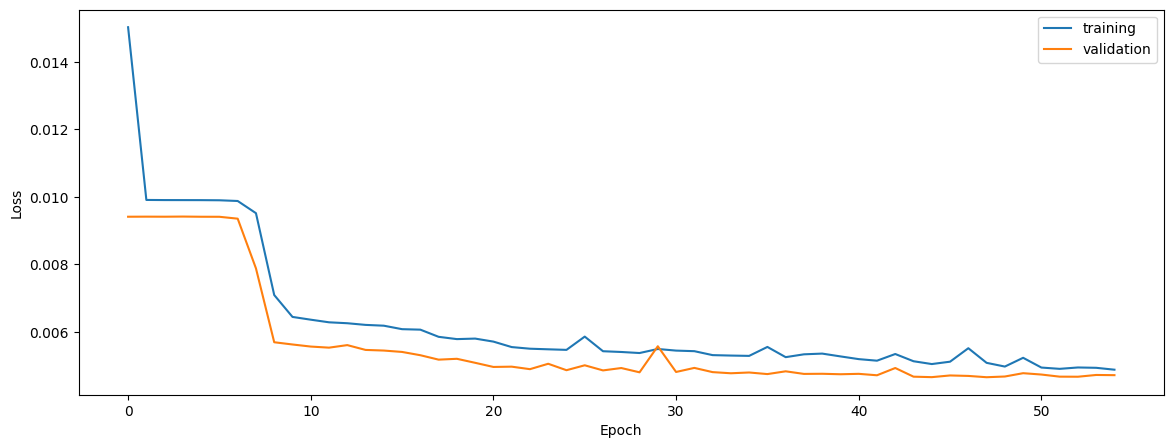

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.70564916694391
0.712402902882546
0.642518744240771


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.70564916694391
0.712402902882546
0.642518744240771


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.7060293808753724
0.7111101436046856
0.6565359051524302


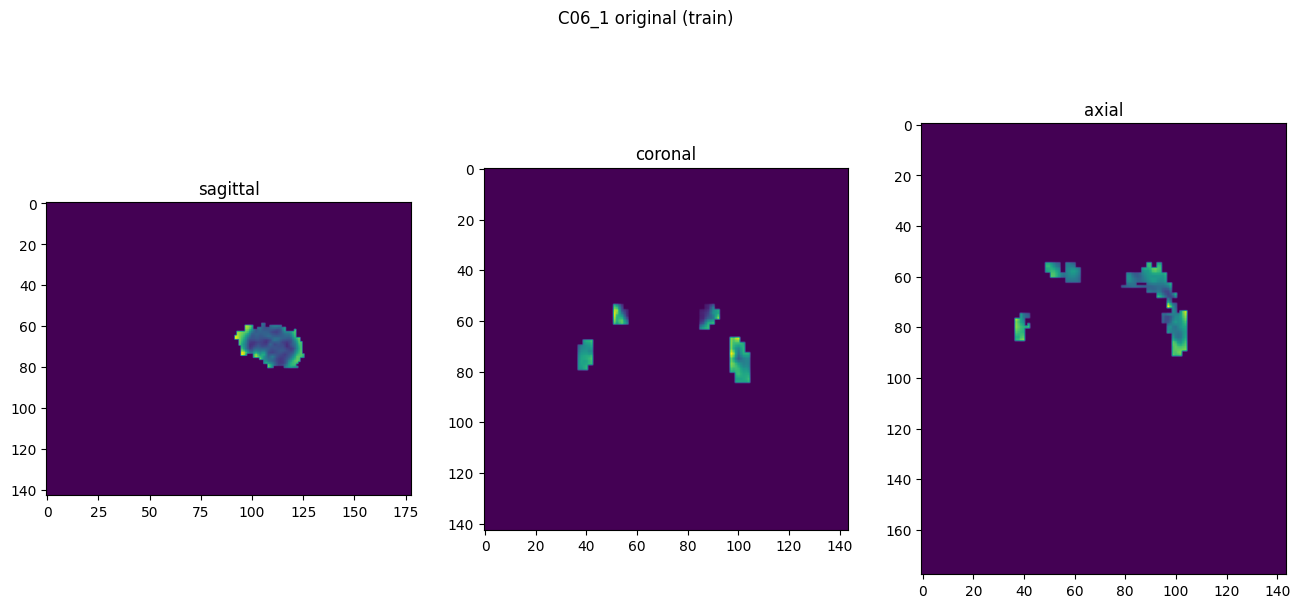

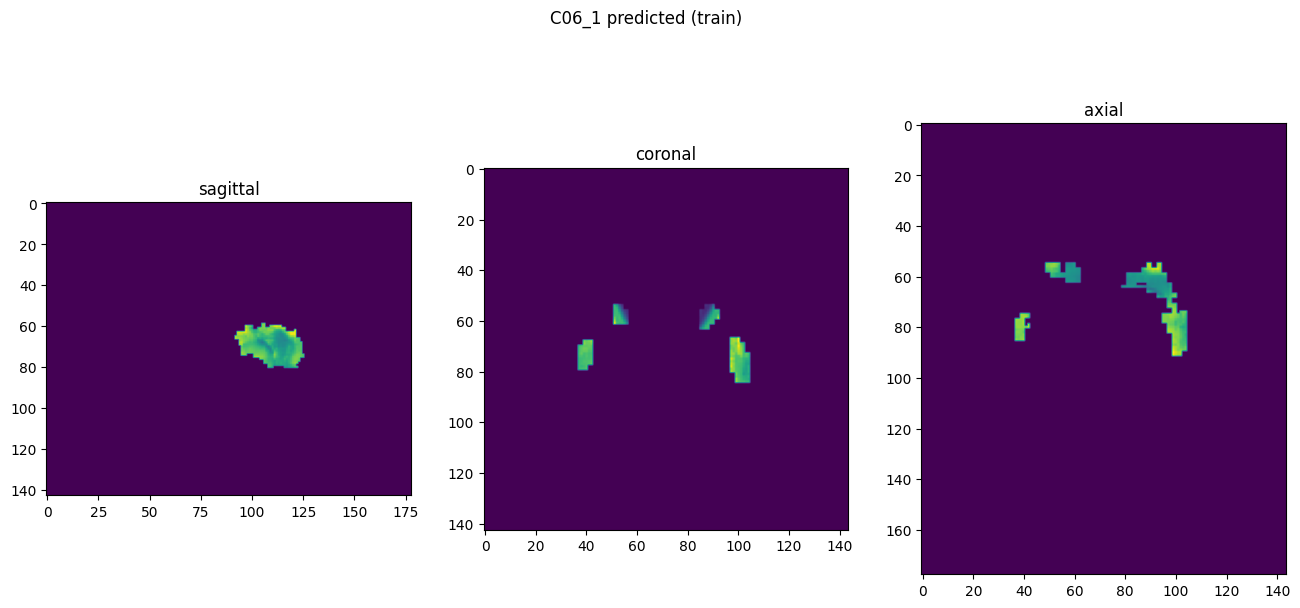

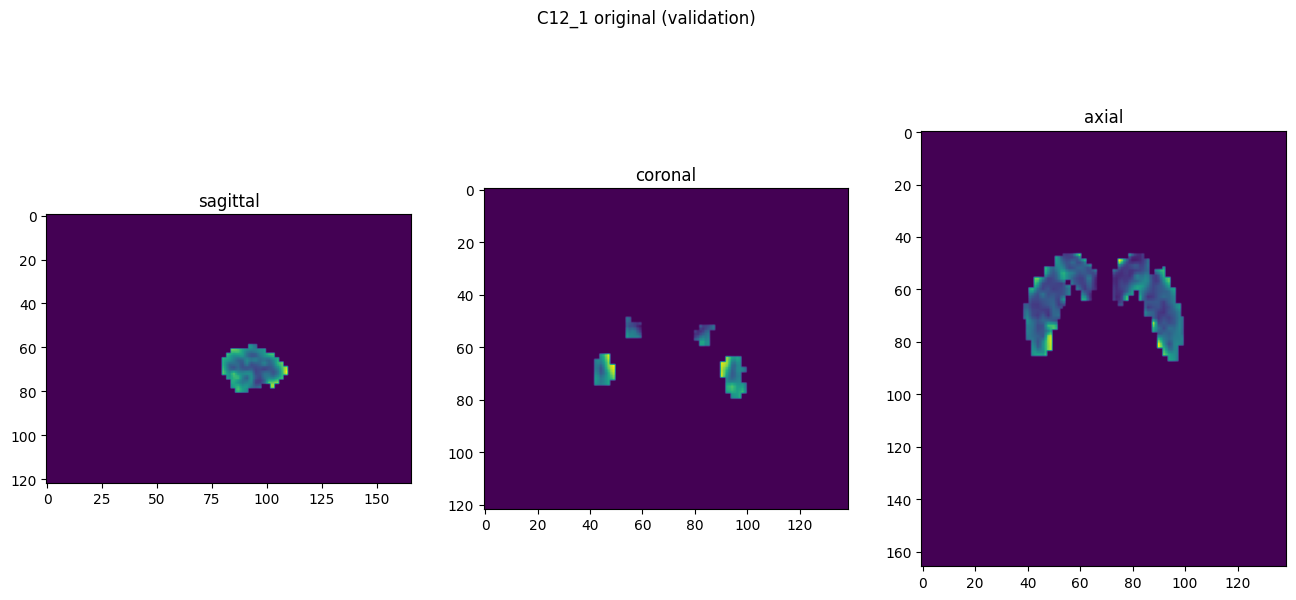

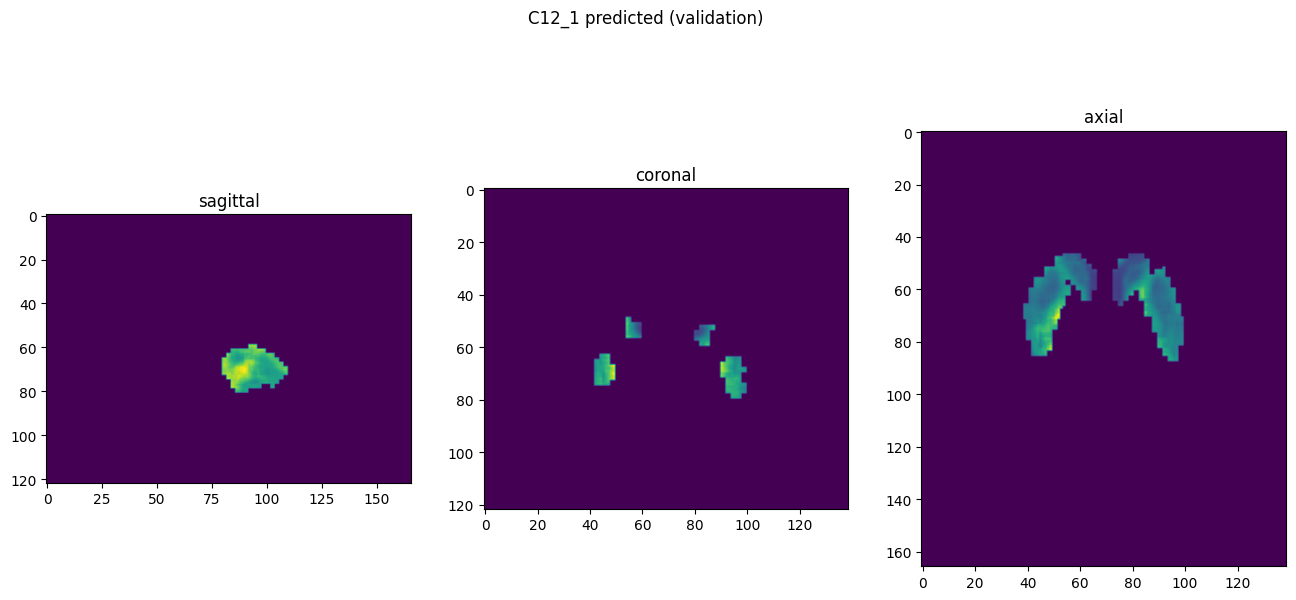

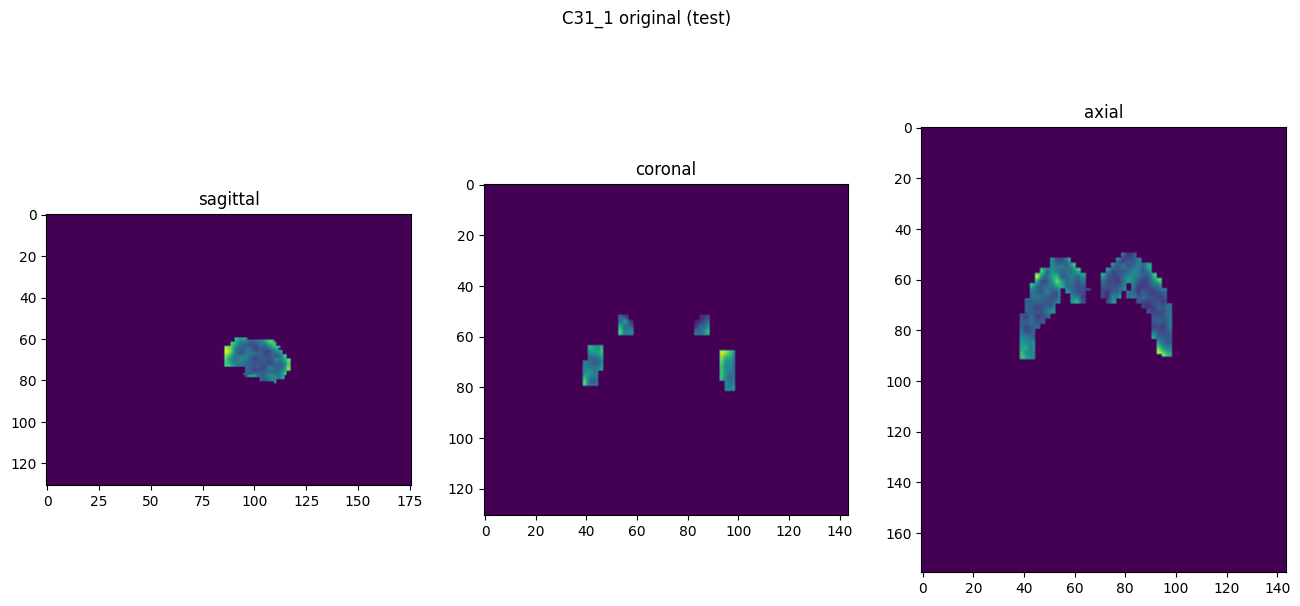

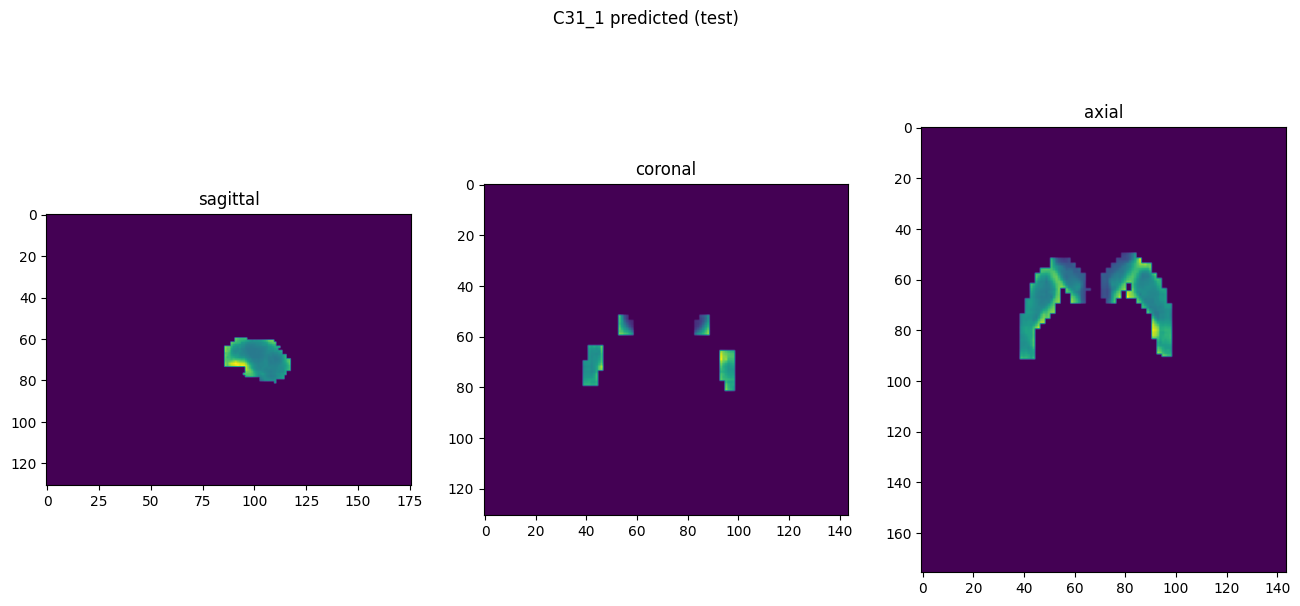

In [10]:
showResults(model, gen, threshold=None, background=False)